In [384]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname('KOH1'), 'src'))
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.width', 1000)           
pd.set_option('display.max_columns', None)     
pd.set_option('display.max_colwidth', None)
from sklearn.manifold import TSNE
from collections import Counter

import kohonen_network
from kohonen_network import KohonenNetwork
import visualizations
importlib.reload(kohonen_network)
importlib.reload(visualizations)
from visualizations import *

import warnings
warnings.filterwarnings('ignore')


In [280]:
def get_dominant_classes(cluster_ids, true_labels):
    dominant_classes = {}
    for cluster_id in np.unique(cluster_ids):
        indices = np.where(cluster_ids == cluster_id)[0]
        true_in_cluster = true_labels[indices]
        most_common = Counter(true_in_cluster).most_common(1)[0][0]
        dominant_classes[cluster_id] = most_common
    return dominant_classes

In [12]:
def analyze_neuron_group_by_dominant_class(som, data, labels, target_class):
    dominant_map = som.class_distribution_in_neurons(data, labels, return_dominant=True)
    target_neurons = [pos for pos, dominant in dominant_map.items() if dominant == target_class]
    
    print(f"Number of neurons with dominant class {target_class}: {len(target_neurons)}")

    class_counts = Counter()
    for x, label in zip(data, labels):
        bmu = som.find_bmu(x)
        if bmu in target_neurons:
            class_counts[label] += 1
    total = sum(class_counts.values())
    print(f"Class distribution in neurons dominated by class {target_class}:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} ({count / total:.2%})")

    if target_class in class_counts:
        del class_counts[target_class]
    if class_counts:
        most_common_other = class_counts.most_common(1)[0]
        print(f"Most frequent other class: {most_common_other[0]} ({most_common_other[1]} samples)")
    else:
        print("No other classes in these neurons.")

In [ ]:
def visualize_clusters_tsne(model, data, true_labels=None, perplexity=30, n_iter=1000, random_state=42):
    weights_flat = model.weights.reshape(-1, model.input_dim)
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    combined = np.vstack([data, weights_flat])
    combined_2d = tsne.fit_transform(combined)
    data_2d = combined_2d[:len(data)]
    weights_2d = combined_2d[len(data):]

    bmu_indices = np.array([model.find_bmu(x) for x in data])
    cluster_ids = bmu_indices[:, 0] * model.N + bmu_indices[:, 1]

    dominant_class_map = get_dominant_classes(cluster_ids, true_labels)
    dominant_class_labels = np.array([dominant_class_map[cid] for cid in cluster_ids])

    num_classes = len(np.unique(dominant_class_labels))
    cmap = plt.get_cmap('tab10', num_classes) if num_classes <= 10 else plt.get_cmap('tab20', num_classes)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=dominant_class_labels, cmap=cmap, alpha=0.7, label='Data points (by dominant class)')
    plt.scatter(weights_2d[:, 0], weights_2d[:, 1], c='black', marker='x', s=100, linewidth=2, label='Neurons')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('SOM + t-SNE: Colored by Dominant Cluster Class')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(scatter, label='Dominant Class')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### MNIST dataset

In [455]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#reshaping 28x28 images to 784 vector and normalizing
X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

print(f"Train data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Train data: (60000, 784)
Test data: (10000, 784)


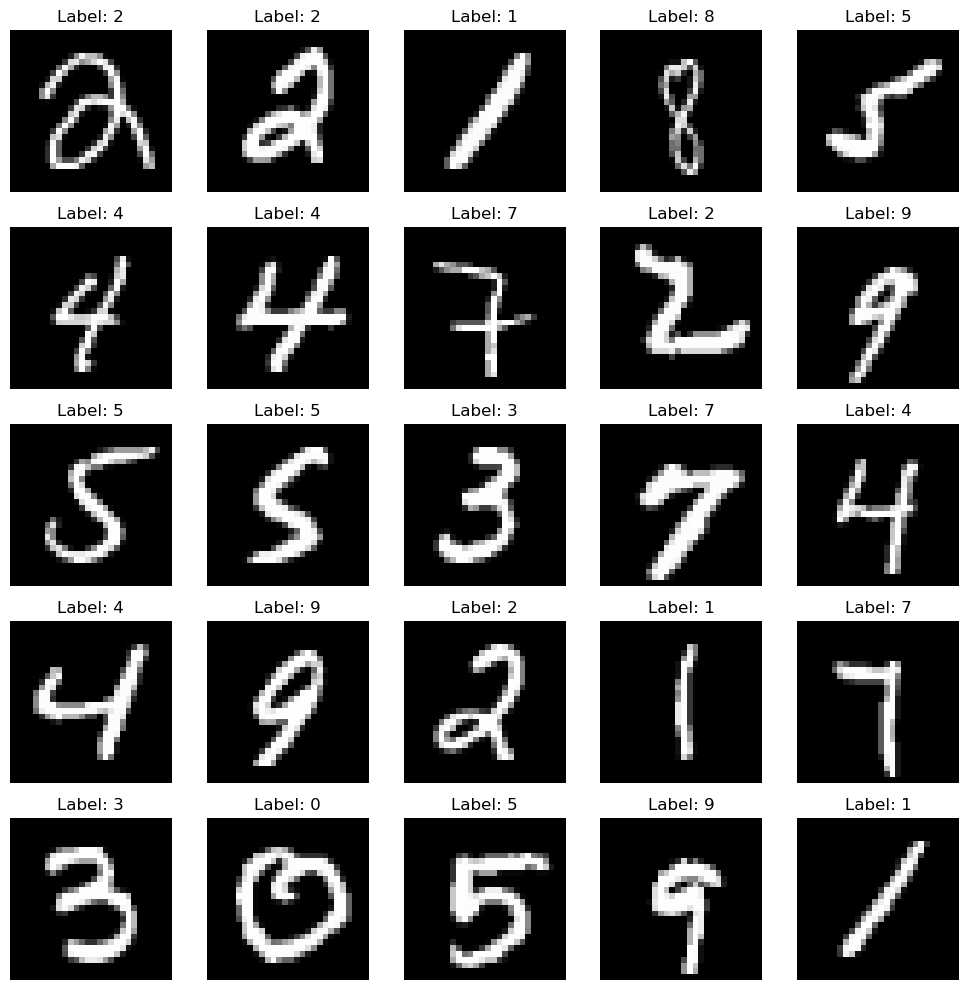

In [286]:
indices = np.random.choice(len(X_train), 25, replace=False)
plt.figure(figsize=(10,10))
for i, idx in enumerate(indices):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

due to high volume of data we'll train Kohonens Network on sample which contains 20% data from original data source

In [401]:
sample_size = int(0.1 * len(X_train))
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train[indices]
y_sample = y_train[indices]

print(f"Train data sample: {X_sample.shape}")

Train data sample: (6000, 784)


#### MNIST recatngular gaussian

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 1.0000
  Quantization Error: 6.3890
  Silhouette Score: -0.0450
  Davies-Bouldin Index: 3.3544
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.3679
  Quantization Error: 5.6224
  Silhouette Score: 0.0516
  Davies-Bouldin Index: 2.8612
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.1353
  Quantization Error: 5.3040
  Silhouette Score: 0.0583
  Davies-Bouldin Index: 2.6714
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.0498
  Quantization Error: 5.2066
  Silhouette Score: 0.0604
  Davies-Bouldin Index: 2.6307
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0183
  Quantization Error: 5.1757
  Silhouette Score: 0.0613
  Davies-Bouldin Index: 2.5952
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0067
  Quantization Error: 5.1680
  Silhouette Score: 0.0612
  Davies-Bouldin 

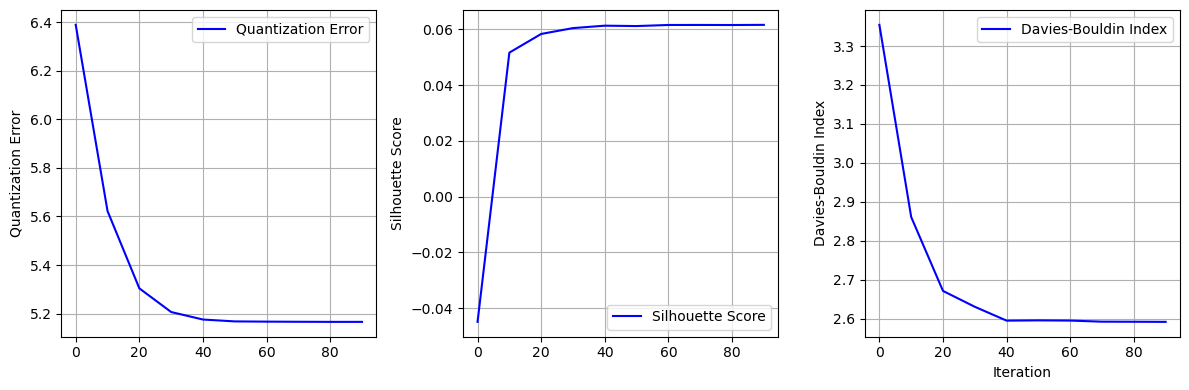

In [312]:
mnist_gaussian_rectangular_lower_lambda = KohonenNetwork(M=10,N=10, input_dim=784, neighbourhood_function='gaussian', topology='rectangular')
mnist_gaussian_rectangular_lower_lambda.fit(X_sample, number_of_iterations=100, lambda_=10, sigma_t=1.0, s=1.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

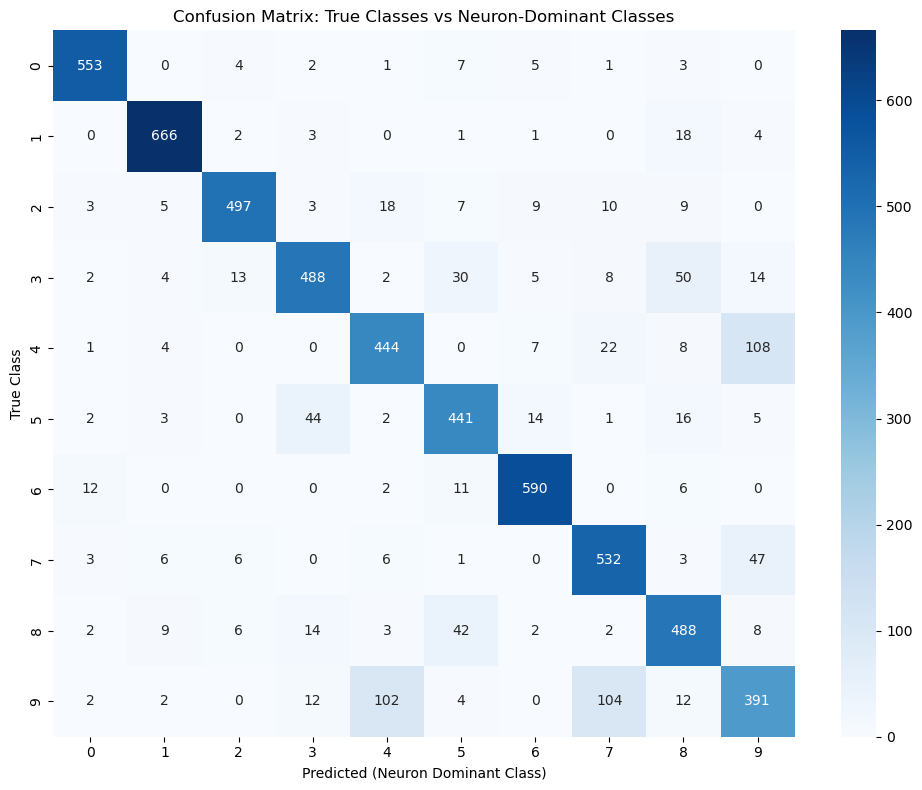

In [313]:
mnist_gaussian_rectangular_lower_lambda.plot_confusion_matrix(X_sample, y_sample)

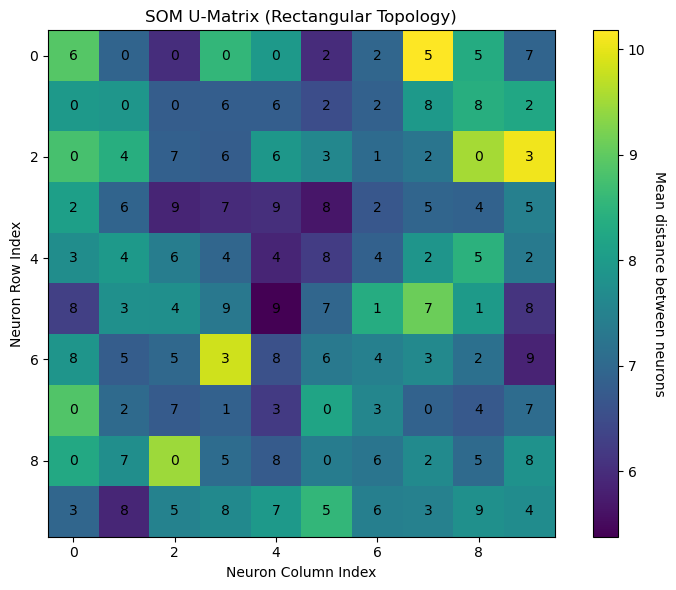

In [314]:
mnist_gaussian_rectangular_lower_lambda.plot_umatrix(X_sample, y_sample)

4 and 9 labels comparison

In [456]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_rectangular_lower_lambda, X_test, y_test, target_class=9)

Number of neurons with dominant class 9: 7
Class distribution in neurons dominated by class 9:
Class 9: 701 (64.08%)
Class 7: 137 (12.52%)
Class 4: 222 (20.29%)
Class 2: 9 (0.82%)
Class 3: 7 (0.64%)
Class 8: 10 (0.91%)
Class 5: 6 (0.55%)
Class 1: 2 (0.18%)
Most frequent other class: 4 (222 samples)


In [457]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_rectangular_lower_lambda, X_test, y_test, target_class=4)

Number of neurons with dominant class 4: 10
Class distribution in neurons dominated by class 4:
Class 4: 712 (76.48%)
Class 5: 8 (0.86%)
Class 9: 169 (18.15%)
Class 6: 7 (0.75%)
Class 8: 6 (0.64%)
Class 2: 20 (2.15%)
Class 7: 8 (0.86%)
Class 3: 1 (0.11%)
Most frequent other class: 9 (169 samples)


3 and 8 labels comaprison

In [462]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_rectangular_lower_lambda, X_test, y_test, target_class=3)

Number of neurons with dominant class 3: 12
Class distribution in neurons dominated by class 3:
Class 2: 17 (1.48%)
Class 3: 892 (77.63%)
Class 5: 73 (6.35%)
Class 1: 26 (2.26%)
Class 4: 15 (1.31%)
Class 9: 28 (2.44%)
Class 8: 86 (7.48%)
Class 7: 8 (0.70%)
Class 0: 2 (0.17%)
Class 6: 2 (0.17%)
Most frequent other class: 8 (86 samples)


In [463]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_rectangular_lower_lambda, X_test, y_test, target_class=8)

Number of neurons with dominant class 8: 9
Class distribution in neurons dominated by class 8:
Class 8: 787 (88.93%)
Class 2: 24 (2.71%)
Class 9: 10 (1.13%)
Class 3: 28 (3.16%)
Class 5: 34 (3.84%)
Class 1: 2 (0.23%)
Most frequent other class: 5 (34 samples)


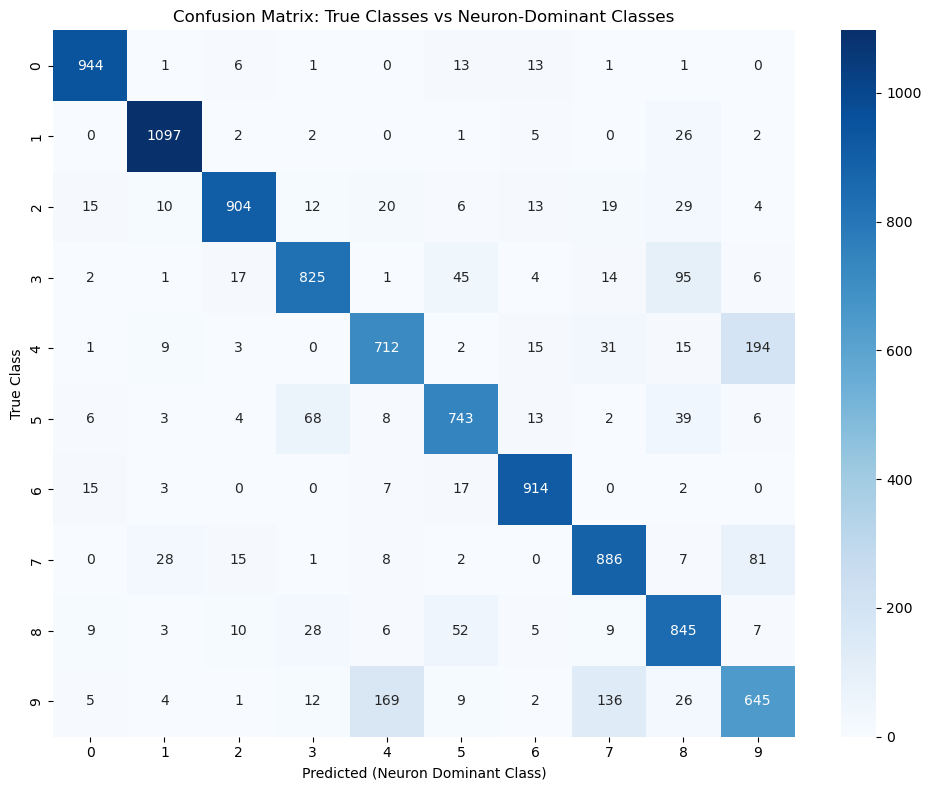

In [317]:
dominant_labels_train = mnist_gaussian_rectangular_lower_lambda.class_distribution_in_neurons(X_train, y_train, return_dominant=True)
mnist_gaussian_rectangular_lower_lambda.plot_confusion_matrix(data=X_test,true_labels=y_test,dominant_labels=dominant_labels_train)

In [424]:
class_to_neurons, neuron_stats = mnist_gaussian_rectangular_lower_lambda.get_neurons_defining_class(X_sample, y_sample)
print_neuron_mapping(class_to_neurons, neuron_stats)

                NEURON CLASS MAPPING REPORT                 
Neuron  Dominant Class Purity          Associated Classes
 (0,1)             0.0  98.2%                      [6, 0]
 (7,5)             0.0  98.2%                      [2, 0]
 (1,1)             0.0  98.1%                      [0, 8]
 (2,8)             0.0  97.9%                      [0, 9]
 (2,0)             0.0  97.1%                      [0, 8]
 (0,3)             0.0  96.6%                      [6, 0]
 (0,4)             0.0  96.4%                      [6, 0]
 (7,0)             0.0  96.0%                   [6, 0, 5]
 (7,7)             0.0  94.1%                   [6, 0, 9]
 (8,2)             0.0  92.0%                      [6, 0]
 (8,5)             0.0  88.6%             [2, 6, 0, 3, 5]
 (1,0)             0.0  83.3%                      [6, 0]
 (8,0)             0.0  81.8%                [6, 0, 9, 3]
 (0,2)             0.0 100.0%                         [0]
 (1,2)             0.0 100.0%                         [0]
 (5,6)     

In [425]:
class_dist = mnist_gaussian_rectangular_lower_lambda.class_distribution_in_neurons(X_sample, y_sample)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples                                          Class Distribution                                         
(0,0)        29                                                                                     4:1(3.4%), 6:28(96.6%)
(0,1)        56                                                                                     0:55(98.2%), 6:1(1.8%)
(0,2)        44                                                                                               0:44(100.0%)
(0,3)        29                                                                                     0:28(96.6%), 6:1(3.4%)
(0,4)        28                                                                                     0:27(96.4%), 6:1(3.6%)
(0,5)        39                             0:2(5.1%), 2:29(74.4%), 3:4(10.3%), 4:1(2.6%), 7:1(2.6%), 8:1(2.6%), 9:1(2.6%)
(0,6)        31                                           

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 5.0000
  Quantization Error: 8.1180
  Silhouette Score: -0.0224
  Davies-Bouldin Index: 4.6303
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 1.8394
  Quantization Error: 6.7787
  Silhouette Score: 0.0187
  Davies-Bouldin Index: 4.2128
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.6767
  Quantization Error: 6.0241
  Silhouette Score: 0.0626
  Davies-Bouldin Index: 2.8870
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.2489
  Quantization Error: 5.8832
  Silhouette Score: 0.0664
  Davies-Bouldin Index: 2.7785
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0916
  Quantization Error: 5.8351
  Silhouette Score: 0.0678
  Davies-Bouldin Index: 2.7138
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0337
  Quantization Error: 5.8184
  Silhouette Score: 0.0695
  Davies-Bouldin 

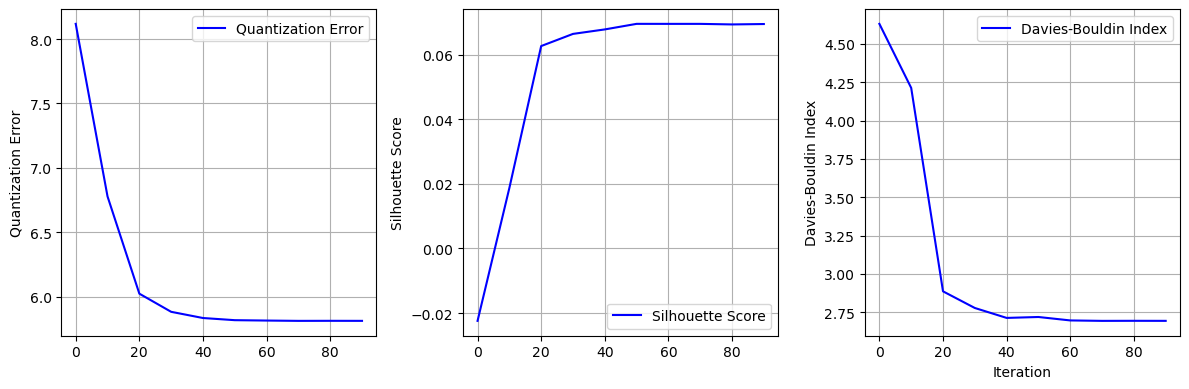

In [324]:
mnist_gaussian_rectangular = KohonenNetwork(M=10,N=2, input_dim=784, neighbourhood_function='gaussian', topology='rectangular')
mnist_gaussian_rectangular.fit(X_sample, number_of_iterations=100, lambda_=10, sigma_t=5.0, s=2.0, 
                               plot_eval_metrics=True, eval_every=10, verbose=True)

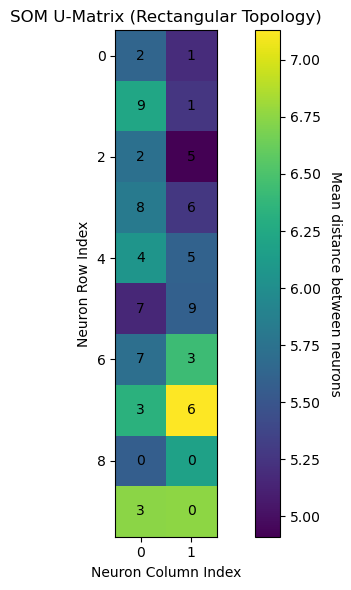

In [325]:
mnist_gaussian_rectangular.plot_umatrix(X_sample, y_sample)

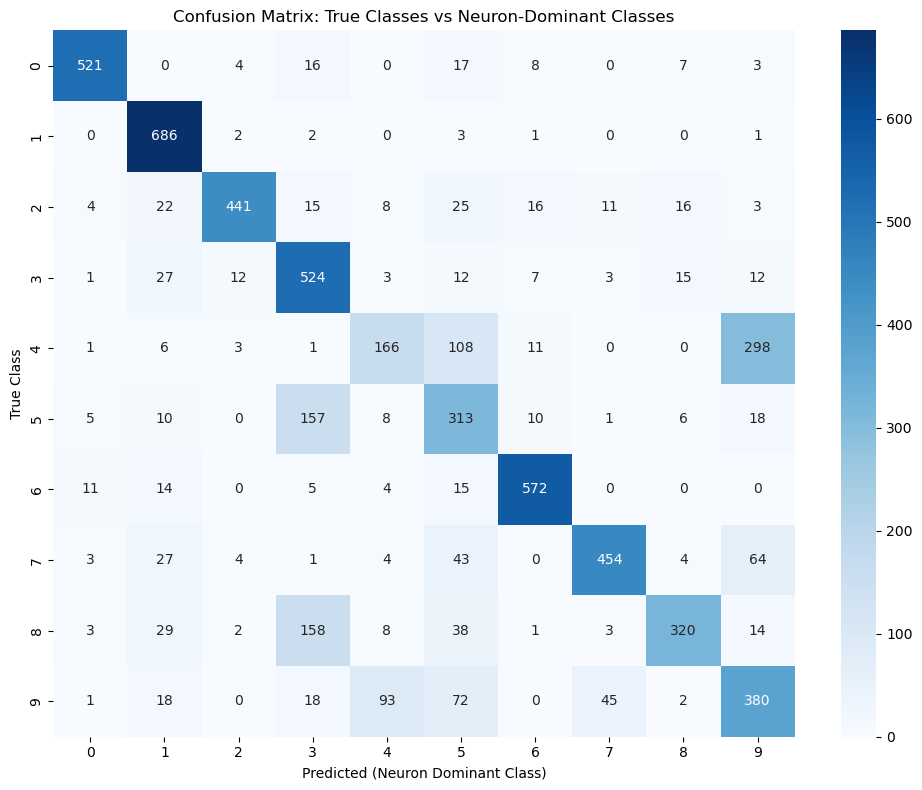

In [326]:
mnist_gaussian_rectangular.plot_confusion_matrix(X_sample, y_sample)

In [327]:
metrics_df= mnist_gaussian_rectangular.calculate_clustering_metrics(X_sample, true_labels=y_sample)
display(metrics_df)

,Silhouette Score,Davies-Bouldin Index,Quantization Error,Number of Clusters
0,0.07,2.7,5.81,20


In [328]:
class_dist = mnist_gaussian_rectangular.class_distribution_in_neurons(X_sample, y_sample)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples                                                     Class Distribution                                                    
(0,0)       251                                                              0:1(0.4%), 1:2(0.8%), 2:239(95.2%), 3:5(2.0%), 7:3(1.2%), 8:1(0.4%)
(0,1)       516                        1:398(77.1%), 2:13(2.5%), 3:26(5.0%), 4:5(1.0%), 5:7(1.4%), 6:7(1.4%), 7:20(3.9%), 8:22(4.3%), 9:18(3.5%)
(1,0)       431                      0:3(0.7%), 1:1(0.2%), 2:3(0.7%), 3:11(2.6%), 4:146(33.9%), 5:12(2.8%), 7:49(11.4%), 8:7(1.6%), 9:199(46.2%)
(1,1)       323                                        1:288(89.2%), 2:9(2.8%), 3:1(0.3%), 4:1(0.3%), 5:3(0.9%), 6:7(2.2%), 7:7(2.2%), 8:7(2.2%)
(2,0)       217                                                              0:3(1.4%), 2:202(93.1%), 3:7(3.2%), 4:3(1.4%), 7:1(0.5%), 8:1(0.5%)
(2,1)       416       0:13(3.1%), 1:3(0.7%), 2:25

In [329]:
class_to_neurons, neuron_stats = mnist_gaussian_rectangular.get_neurons_defining_class(X_sample, y_sample)
print_neuron_mapping(class_to_neurons, neuron_stats)

                NEURON CLASS MAPPING REPORT                 
Neuron  Dominant Class Purity             Associated Classes
 (8,1)               0  97.9%                   [8, 0, 6, 7]
 (8,0)               0  93.7%          [8, 2, 0, 5, 6, 3, 7]
 (9,1)               0  92.4%          [4, 8, 2, 0, 5, 6, 9]
 (1,1)               1  89.2%       [4, 8, 2, 5, 6, 1, 3, 7]
 (0,1)               1  77.1%    [4, 8, 2, 5, 6, 1, 9, 3, 7]
 (0,0)               2  95.2%             [8, 2, 0, 1, 3, 7]
 (2,0)               2  93.1%             [4, 8, 2, 0, 3, 7]
 (7,0)               3  80.4%          [8, 2, 0, 5, 6, 9, 3]
 (6,1)               3  56.5%    [4, 8, 2, 0, 5, 1, 9, 3, 7]
 (9,0)               3  39.9%             [8, 0, 5, 6, 9, 3]
 (4,0)               4  56.5%       [4, 8, 2, 5, 6, 9, 3, 7]
 (4,1)               5  89.1%          [4, 8, 0, 5, 6, 9, 3]
 (2,1)               5  26.0% [4, 8, 2, 0, 5, 6, 1, 9, 3, 7]
 (7,1)               6  96.5%          [4, 8, 2, 0, 5, 6, 3]
 (3,1)               6  

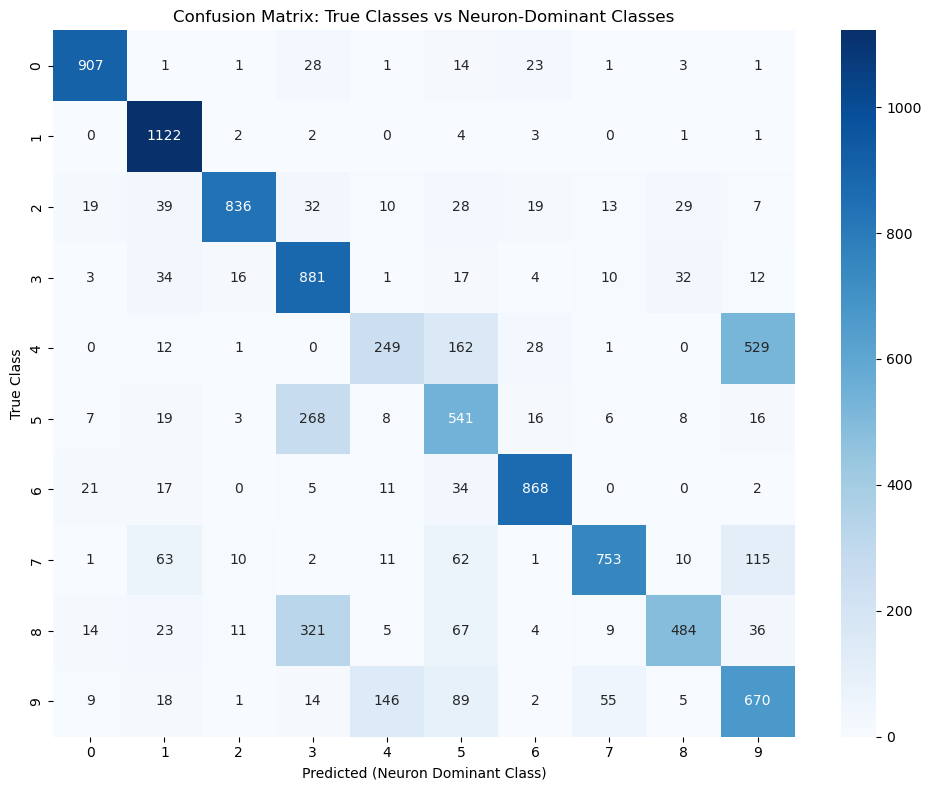

In [330]:
dominant_labels_train = mnist_gaussian_rectangular.class_distribution_in_neurons(X_train, y_train, return_dominant=True)
mnist_gaussian_rectangular.plot_confusion_matrix(data=X_test,true_labels=y_test,dominant_labels=dominant_labels_train)

#### MNIST hexagon gaussian

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 1.0000
  Quantization Error: 6.4673
  Silhouette Score: -0.0552
  Davies-Bouldin Index: 3.5596
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.3679
  Quantization Error: 5.5976
  Silhouette Score: 0.0426
  Davies-Bouldin Index: 2.8987
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.1353
  Quantization Error: 5.3258
  Silhouette Score: 0.0590
  Davies-Bouldin Index: 2.6917
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.0498
  Quantization Error: 5.1944
  Silhouette Score: 0.0578
  Davies-Bouldin Index: 2.5787
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0183
  Quantization Error: 5.1627
  Silhouette Score: 0.0594
  Davies-Bouldin Index: 2.5578
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0067
  Quantization Error: 5.1576
  Silhouette Score: 0.0598
  Davies-Bouldin 

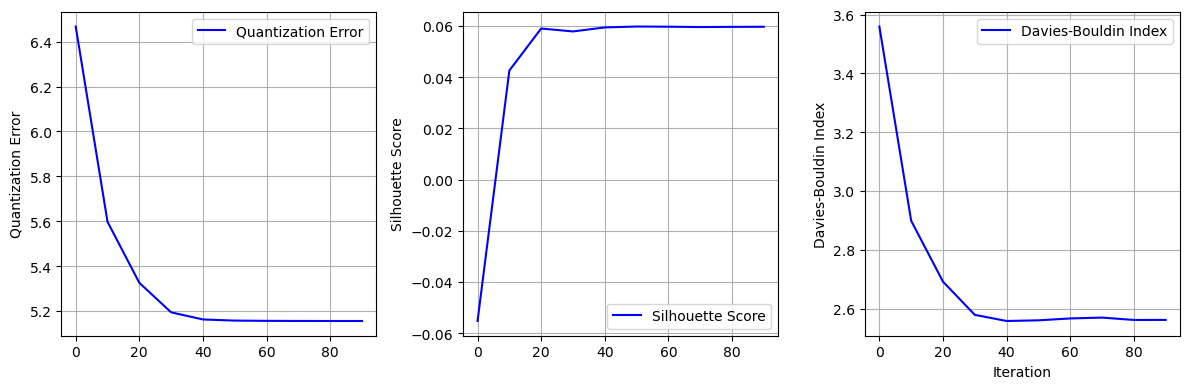

In [402]:
mnist_gaussian_hexagon = KohonenNetwork(M=10,N=10, input_dim=784, neighbourhood_function='gaussian', topology='hexagonal')
mnist_gaussian_hexagon.fit(X_sample, number_of_iterations=100, lambda_=10, sigma_t=1.0, s=1.0, 
                           plot_eval_metrics=True, eval_every=10, verbose=True)

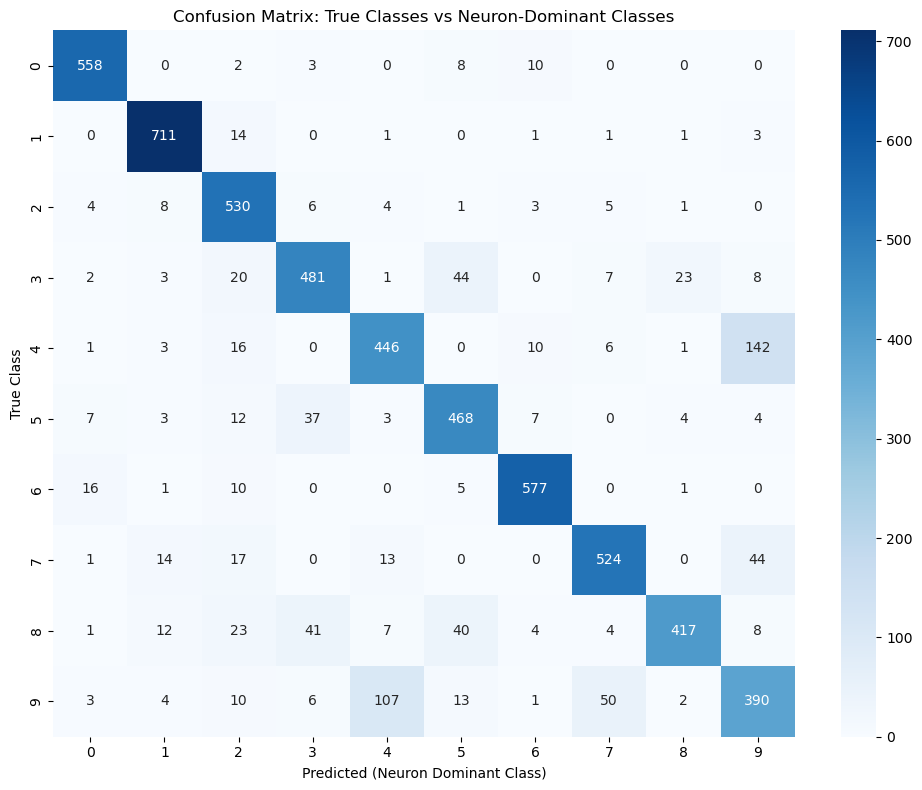

In [403]:
mnist_gaussian_hexagon.plot_confusion_matrix(X_sample, y_sample)

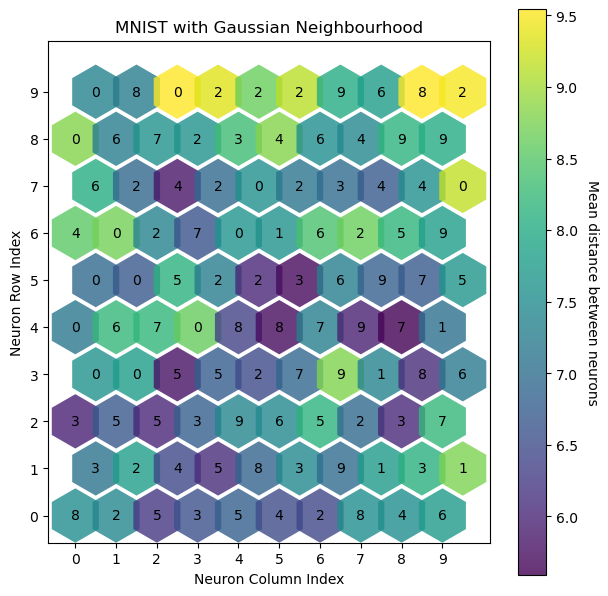

In [404]:
mnist_gaussian_hexagon.plot_umatrix(X_sample, y_sample)

In [458]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_hexagon, X_test, y_test, target_class=9)

Number of neurons with dominant class 9: 8
Class distribution in neurons dominated by class 9:
Class 9: 722 (66.73%)
Class 4: 244 (22.55%)
Class 7: 85 (7.86%)
Class 8: 12 (1.11%)
Class 3: 9 (0.83%)
Class 5: 9 (0.83%)
Class 1: 1 (0.09%)
Most frequent other class: 4 (244 samples)


In [459]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_hexagon, X_test, y_test, target_class=4)

Number of neurons with dominant class 4: 9
Class distribution in neurons dominated by class 4:
Class 4: 678 (77.40%)
Class 9: 152 (17.35%)
Class 7: 20 (2.28%)
Class 8: 13 (1.48%)
Class 5: 3 (0.34%)
Class 6: 6 (0.68%)
Class 2: 3 (0.34%)
Class 0: 1 (0.11%)
Most frequent other class: 9 (152 samples)


In [460]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_hexagon, X_test, y_test, target_class=3)

Number of neurons with dominant class 3: 10
Class distribution in neurons dominated by class 3:
Class 3: 855 (84.65%)
Class 2: 13 (1.29%)
Class 5: 51 (5.05%)
Class 8: 70 (6.93%)
Class 9: 8 (0.79%)
Class 0: 9 (0.89%)
Class 1: 2 (0.20%)
Class 7: 2 (0.20%)
Most frequent other class: 8 (70 samples)


In [461]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_hexagon, X_test, y_test, target_class=8)

Number of neurons with dominant class 8: 9
Class distribution in neurons dominated by class 8:
Class 8: 748 (90.12%)
Class 9: 8 (0.96%)
Class 2: 14 (1.69%)
Class 5: 17 (2.05%)
Class 3: 38 (4.58%)
Class 1: 4 (0.48%)
Class 4: 1 (0.12%)
Most frequent other class: 3 (38 samples)


In [405]:
class_to_neurons, neuron_stats = mnist_gaussian_hexagon.get_neurons_defining_class(X_sample, y_sample)
print_neuron_mapping(class_to_neurons, neuron_stats)

                NEURON CLASS MAPPING REPORT                 
Neuron  Dominant Class Purity          Associated Classes
 (6,4)               0  98.1%                      [6, 0]
 (6,1)               0  98.0%                      [6, 0]
 (3,0)               0  97.9%                      [0, 9]
 (9,0)               0  97.0%                   [6, 0, 5]
 (4,3)               0  96.6%                      [6, 0]
 (5,0)               0  96.5%                      [2, 0]
 (3,1)               0  73.2%       [2, 6, 0, 9, 8, 5, 4]
 (7,4)               0  72.7%                [6, 0, 9, 7]
 (8,0)               0  65.0%                [6, 0, 3, 5]
 (4,0)               0 100.0%                         [0]
 (5,1)               0 100.0%                         [0]
 (7,9)               0 100.0%                         [0]
 (9,2)               0 100.0%                         [0]
 (3,7)               1  96.5%                [2, 1, 9, 7]
 (6,5)               1  95.0%       [2, 1, 9, 7, 3, 8, 4]
 (1,7)     

In [406]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_hexagon, X_sample, y_sample, target_class=4)

Number of neurons with dominant class 4: 9
Class distribution in neurons dominated by class 4:
Class 4: 446 (76.63%)
Class 9: 107 (18.38%)
Class 8: 7 (1.20%)
Class 2: 4 (0.69%)
Class 3: 1 (0.17%)
Class 5: 3 (0.52%)
Class 7: 13 (2.23%)
Class 1: 1 (0.17%)
Most frequent other class: 9 (107 samples)


In [407]:
analyze_neuron_group_by_dominant_class(mnist_gaussian_hexagon, X_sample, y_sample, target_class=9)

Number of neurons with dominant class 9: 9
Class distribution in neurons dominated by class 9:
Class 9: 390 (65.11%)
Class 3: 8 (1.34%)
Class 7: 44 (7.35%)
Class 4: 142 (23.71%)
Class 1: 3 (0.50%)
Class 8: 8 (1.34%)
Class 5: 4 (0.67%)
Most frequent other class: 4 (142 samples)


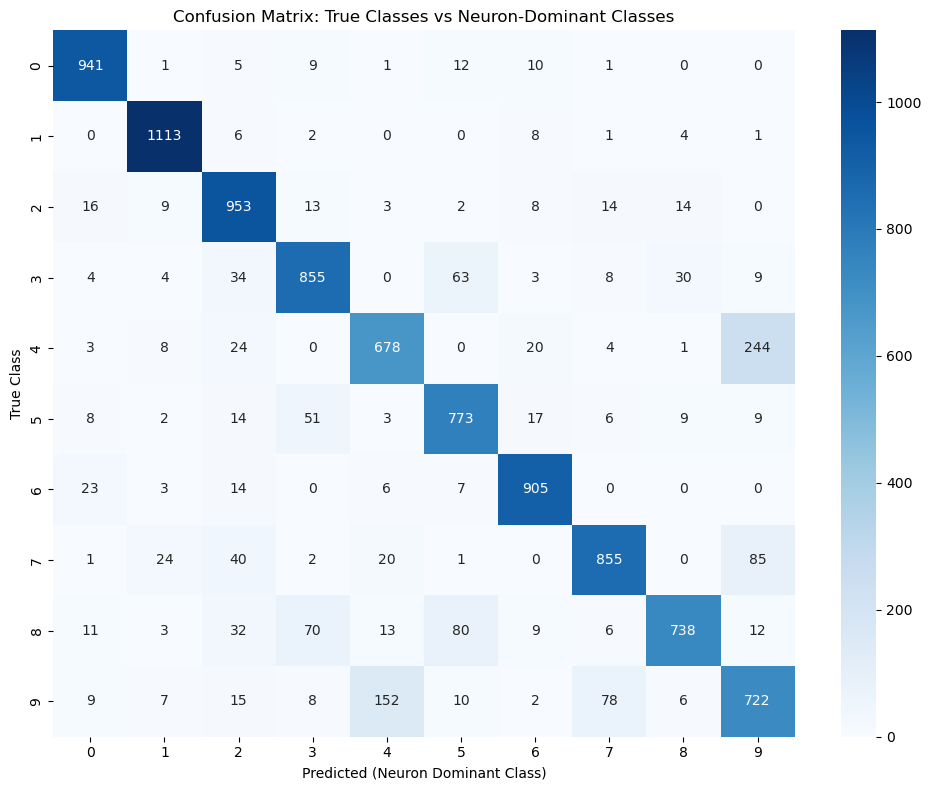

In [408]:
dominant_labels_train = mnist_gaussian_hexagon.class_distribution_in_neurons(X_train, y_train, return_dominant=True)
mnist_gaussian_hexagon.plot_confusion_matrix(data=X_test,true_labels=y_test,dominant_labels=dominant_labels_train)

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 5.0000
  Quantization Error: 7.9365
  Silhouette Score: -0.0485
  Davies-Bouldin Index: 3.7866
Iteration 10:
  Learning Rate (alpha): 0.6065
  Neighborhood Size (sigma): 3.0327
  Quantization Error: 7.1251
  Silhouette Score: -0.0470
  Davies-Bouldin Index: 5.0395
Iteration 20:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 1.8394
  Quantization Error: 6.4958
  Silhouette Score: -0.0190
  Davies-Bouldin Index: 4.8279
Iteration 30:
  Learning Rate (alpha): 0.2231
  Neighborhood Size (sigma): 1.1157
  Quantization Error: 6.0187
  Silhouette Score: 0.0072
  Davies-Bouldin Index: 4.1240
Iteration 40:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.6767
  Quantization Error: 5.5413
  Silhouette Score: 0.0289
  Davies-Bouldin Index: 3.3437
Iteration 50:
  Learning Rate (alpha): 0.0821
  Neighborhood Size (sigma): 0.4104
  Quantization Error: 5.2214
  Silhouette Score: 0.0469
  Davies-Bouldi

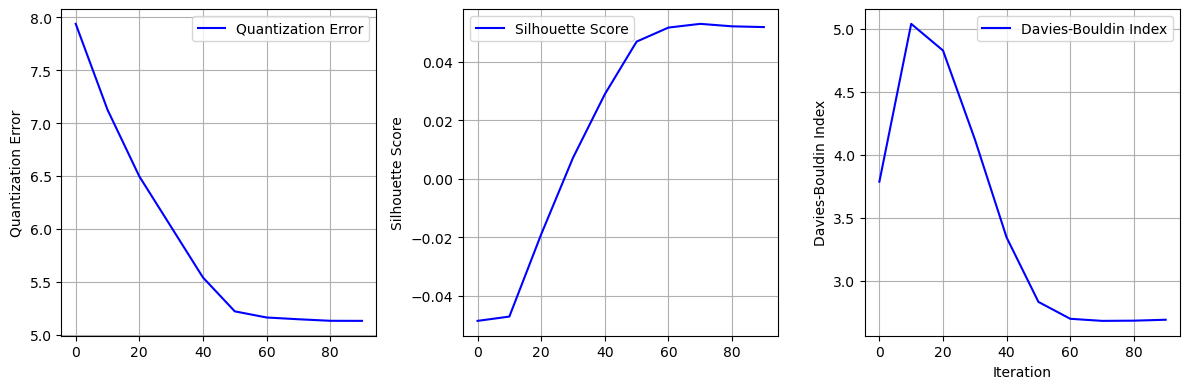

In [409]:
mnist_gaussian_hexagon_different_parameters = KohonenNetwork(M=10,N=10, input_dim=784, 
                                                             neighbourhood_function='gaussian', topology='hexagonal')
mnist_gaussian_hexagon_different_parameters.fit(X_sample, number_of_iterations=100, lambda_=20, sigma_t=5.0, s=1.0, 
                           plot_eval_metrics=True, eval_every=10, verbose=True)

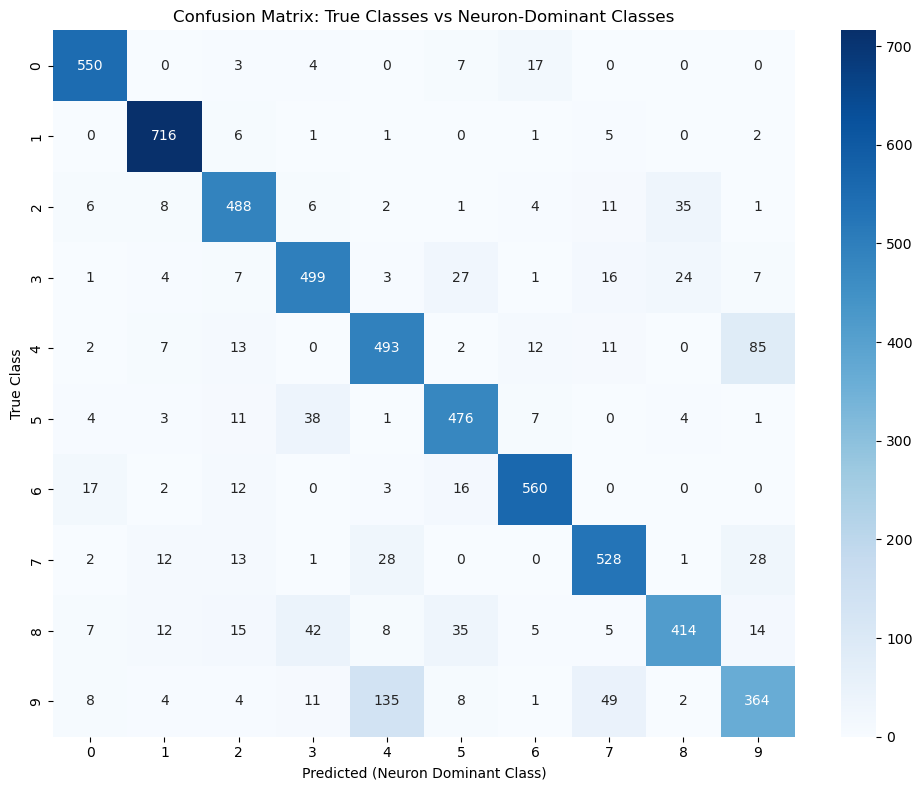

In [410]:
mnist_gaussian_hexagon_different_parameters.plot_confusion_matrix(X_sample, y_sample)

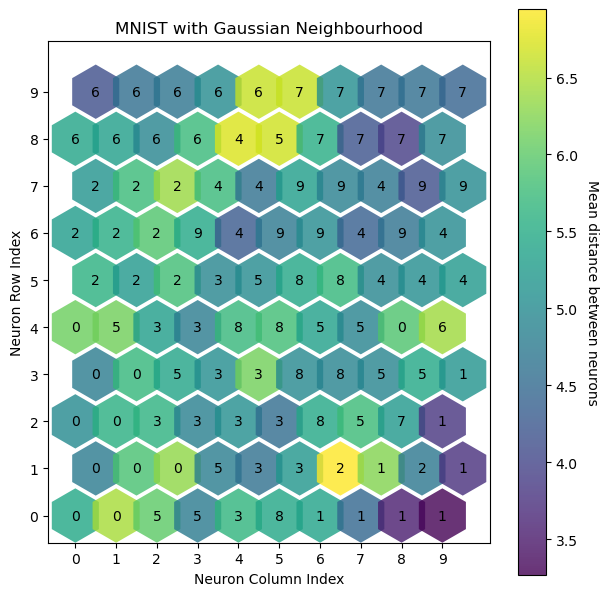

In [411]:
mnist_gaussian_hexagon_different_parameters.plot_umatrix(X_sample, y_sample)

In [412]:
class_to_neurons, neuron_stats = mnist_gaussian_hexagon_different_parameters.get_neurons_defining_class(X_sample, y_sample)
print_neuron_mapping(class_to_neurons, neuron_stats)

                NEURON CLASS MAPPING REPORT                 
Neuron  Dominant Class Purity          Associated Classes
 (3,0)               0  98.4%                      [0, 8]
 (1,1)               0  98.2%                      [6, 0]
 (0,0)               0  98.1%                      [6, 0]
 (3,1)               0  96.6%                   [0, 9, 5]
 (1,0)               0  95.9%                      [2, 0]
 (0,1)               0  94.5%                   [6, 0, 8]
 (1,2)               0  94.1%                   [0, 9, 8]
 (4,0)               0  81.2%          [6, 0, 9, 3, 8, 5]
 (4,8)               0  41.9%    [2, 6, 0, 9, 7, 8, 5, 4]
 (2,0)               0 100.0%                         [0]
 (2,1)               0 100.0%                         [0]
 (0,6)               1  98.4%                   [2, 1, 7]
 (2,9)               1  97.8%                [2, 6, 1, 3]
 (0,7)               1  94.8%             [1, 9, 7, 8, 4]
 (0,9)               1  94.5%                      [1, 8]
 (0,8)     

In [413]:
class_dist = mnist_gaussian_hexagon_different_parameters.class_distribution_in_neurons(X_sample, y_sample)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples                                             Class Distribution                                            
(0,0)        54                                                                                           0:53(98.1%), 6:1(1.9%)
(0,1)        73                                                                                0:69(94.5%), 6:2(2.7%), 8:2(2.7%)
(0,2)        52                                                                                3:3(5.8%), 5:46(88.5%), 8:3(5.8%)
(0,3)        40                                                                                                     5:40(100.0%)
(0,4)        54                                               0:1(1.9%), 1:1(1.9%), 2:2(3.7%), 3:45(83.3%), 5:4(7.4%), 8:1(1.9%)
(0,5)        97                                                                   2:26(26.8%), 3:4(4.1%), 7:1(1.0%), 8:66(68.0%)
(0,6)       123 

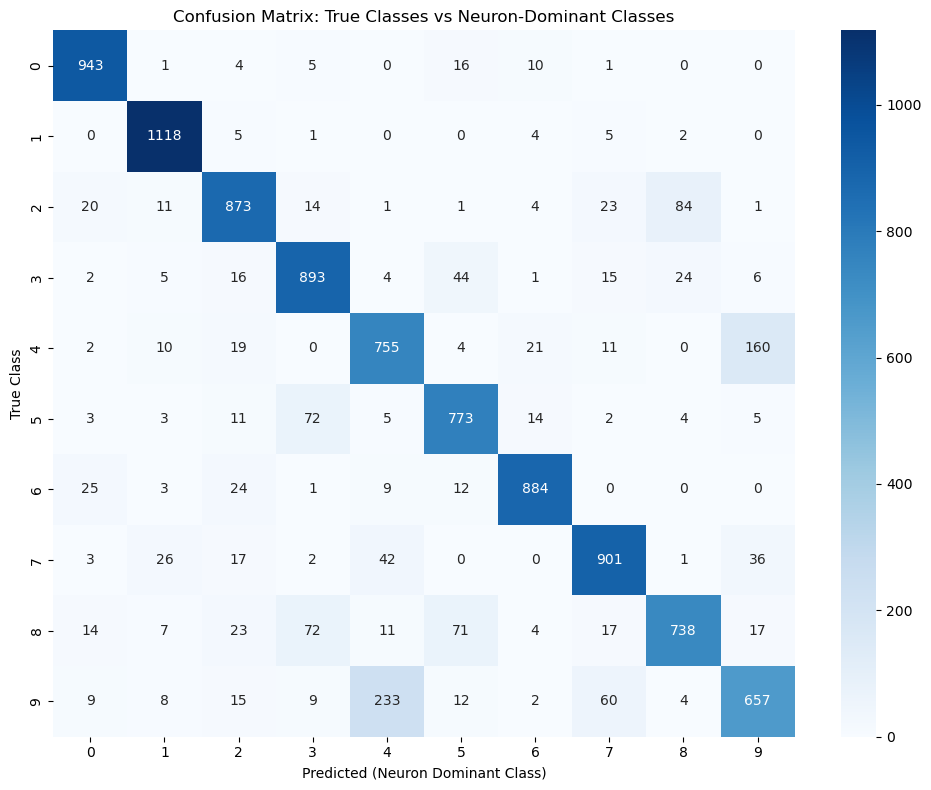

In [414]:
dominant_labels_train = mnist_gaussian_hexagon_different_parameters.class_distribution_in_neurons(X_train, y_train, return_dominant=True)
mnist_gaussian_hexagon_different_parameters.plot_confusion_matrix(data=X_test,true_labels=y_test,dominant_labels=dominant_labels_train)

#### MNIST rectangular mexican hat

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 0.1000
  Quantization Error: 8.8381
  Silhouette Score: 0.0518
  Davies-Bouldin Index: 3.5868
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.0368
  Quantization Error: 7.3008
  Silhouette Score: 0.0611
  Davies-Bouldin Index: 3.4946
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.0135
  Quantization Error: 6.7918
  Silhouette Score: 0.0567
  Davies-Bouldin Index: 3.1239
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.0050
  Quantization Error: 6.5516
  Silhouette Score: 0.0647
  Davies-Bouldin Index: 3.0008
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0018
  Quantization Error: 6.5190
  Silhouette Score: 0.0674
  Davies-Bouldin Index: 2.9225
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0007
  Quantization Error: 6.4975
  Silhouette Score: 0.0662
  Davies-Bouldin I

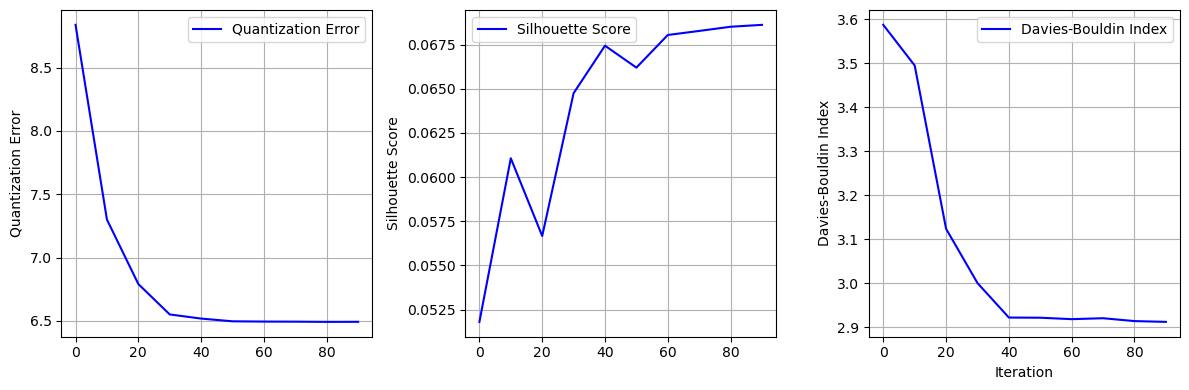

In [361]:
mnist_mexican_hat_rectangular = KohonenNetwork(M=10,N=10, input_dim=784, neighbourhood_function='mexican_hat', topology='rectangular')
mnist_mexican_hat_rectangular.fit(X_sample, number_of_iterations=100, lambda_=10, sigma_t=0.1, s=5.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

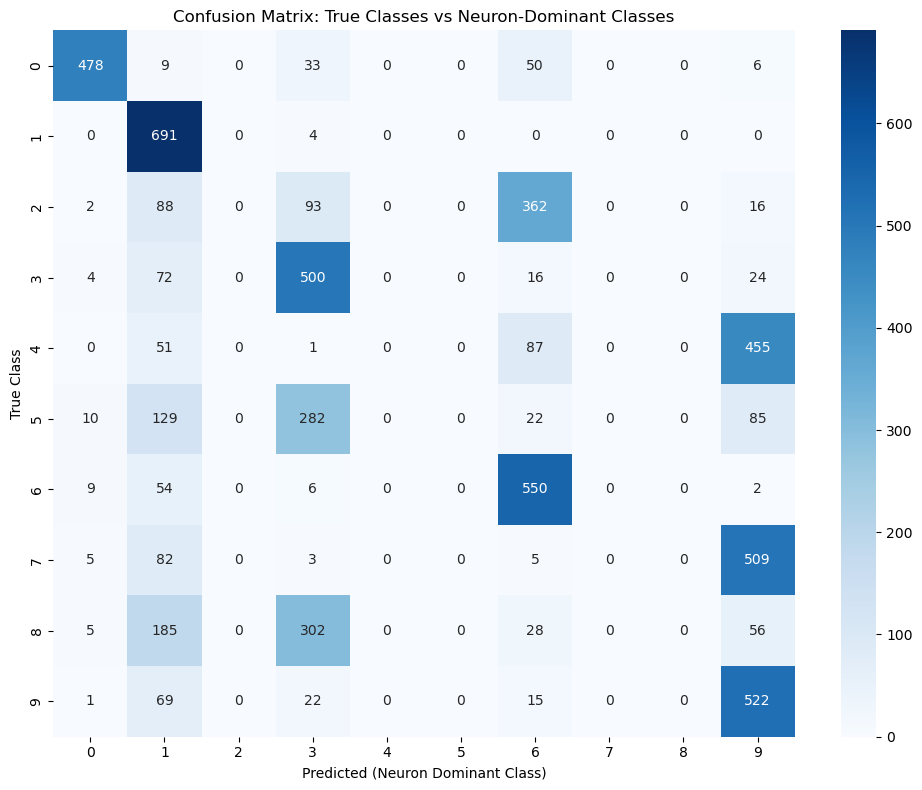

In [362]:
mnist_mexican_hat_rectangular.plot_confusion_matrix(X_sample, y_sample)

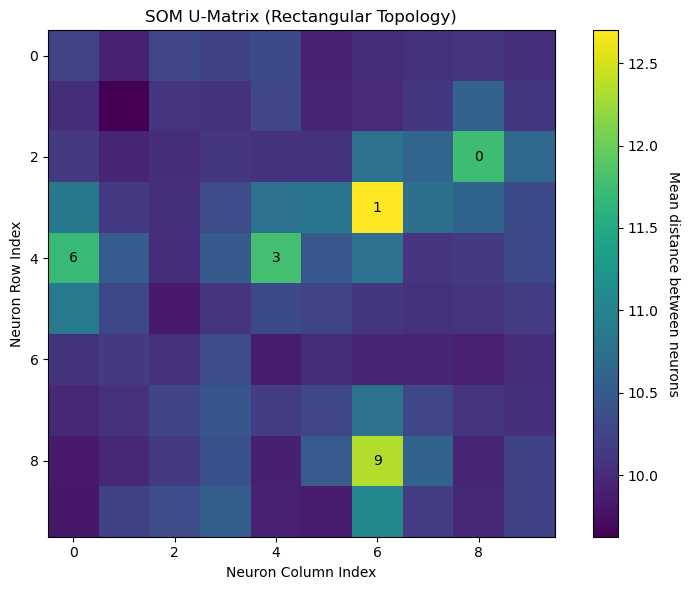

In [363]:
mnist_mexican_hat_rectangular.plot_umatrix(X_sample, y_sample)

In [364]:
class_dist = mnist_mexican_hat_rectangular.class_distribution_in_neurons(X_sample, y_sample)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples                                                     Class Distribution                                                    
(0,0)          0                                                                                                                           Empty
(0,1)          0                                                                                                                           Empty
(0,2)          0                                                                                                                           Empty
(0,3)          0                                                                                                                           Empty
(0,4)          0                                                                                                                           Empty
(0,5)          0                                 

In [365]:
class_to_neurons, neuron_stats = mnist_mexican_hat_rectangular.get_neurons_defining_class(X_sample, y_sample)
print_neuron_mapping(class_to_neurons, neuron_stats)

                NEURON CLASS MAPPING REPORT                 
Neuron  Dominant Class Purity             Associated Classes
 (2,8)             0.0  93.0%       [8, 2, 0, 5, 6, 9, 3, 7]
 (3,6)             1.0  48.3% [4, 8, 2, 0, 5, 6, 1, 9, 3, 7]
 (4,4)             3.0  40.1% [4, 8, 2, 0, 5, 6, 1, 9, 3, 7]
 (4,0)             6.0  48.5%    [4, 8, 2, 0, 5, 6, 9, 3, 7]
 (8,6)             9.0  31.2%    [4, 8, 2, 0, 5, 6, 9, 3, 7]
 (0,0)             NaN   0.0%                             []
 (0,1)             NaN   0.0%                             []
 (0,2)             NaN   0.0%                             []
 (0,3)             NaN   0.0%                             []
 (0,4)             NaN   0.0%                             []
 (0,5)             NaN   0.0%                             []
 (0,6)             NaN   0.0%                             []
 (0,7)             NaN   0.0%                             []
 (0,8)             NaN   0.0%                             []
 (0,9)             NaN  

#### MNIST hexagon mexican hat

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 0.1000
  Quantization Error: 9.1394
  Silhouette Score: 0.0442
  Davies-Bouldin Index: 3.9300
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.0368
  Quantization Error: 7.3412
  Silhouette Score: 0.0715
  Davies-Bouldin Index: 3.6752
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.0135
  Quantization Error: 6.8438
  Silhouette Score: 0.0639
  Davies-Bouldin Index: 3.2283
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.0050
  Quantization Error: 6.7305
  Silhouette Score: 0.0598
  Davies-Bouldin Index: 3.3525
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0018
  Quantization Error: 6.6507
  Silhouette Score: 0.0607
  Davies-Bouldin Index: 3.2682
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0007
  Quantization Error: 6.6249
  Silhouette Score: 0.0587
  Davies-Bouldin I

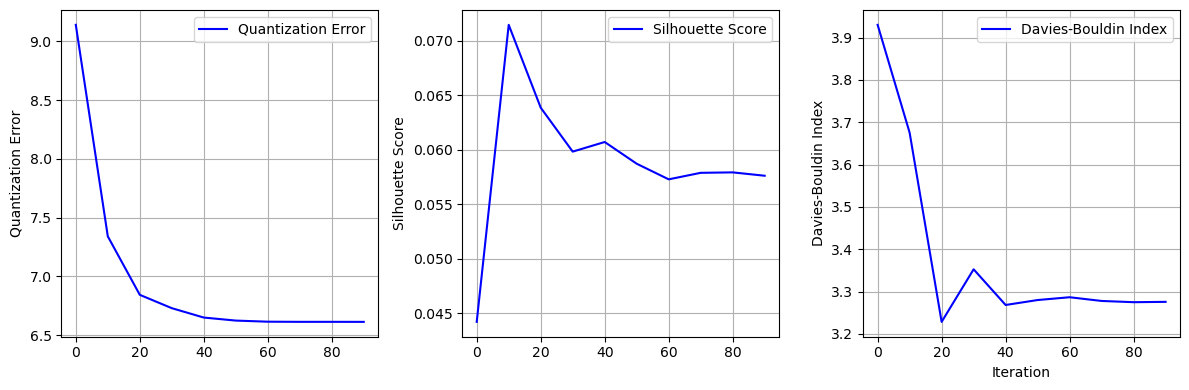

In [415]:
mnist_mexican_hat_hexagon = KohonenNetwork(M=10,N=10, input_dim=784, neighbourhood_function='mexican_hat', topology='hexagonal')
mnist_mexican_hat_hexagon.fit(X_sample, number_of_iterations=100, lambda_=10, sigma_t=0.1, s=5.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

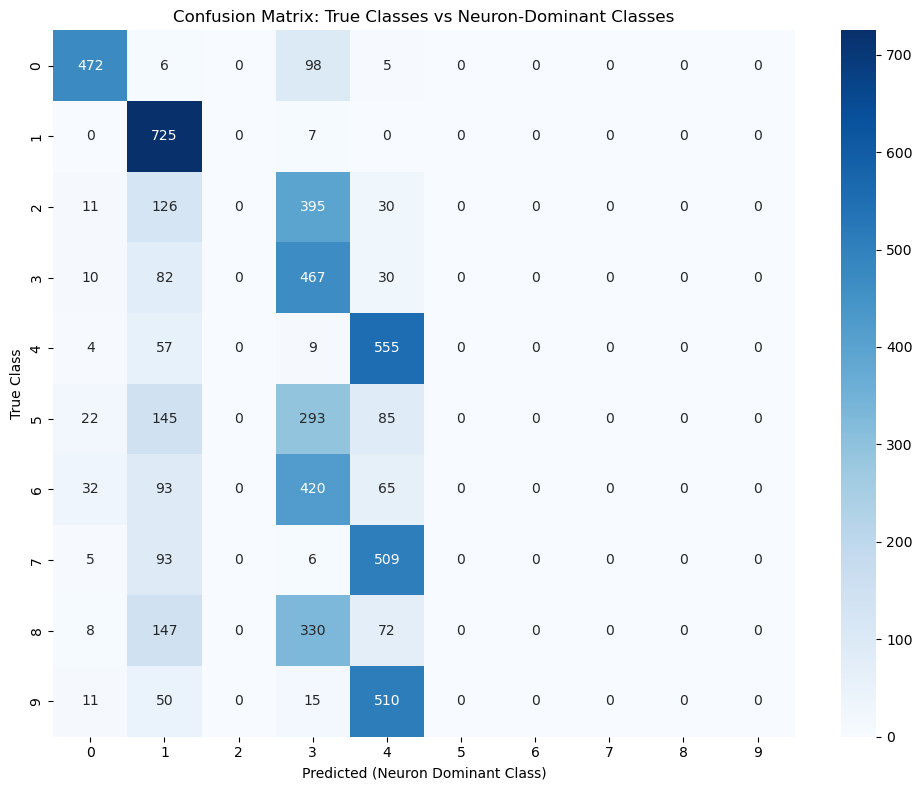

In [416]:
mnist_mexican_hat_hexagon.plot_confusion_matrix(X_sample, y_sample)

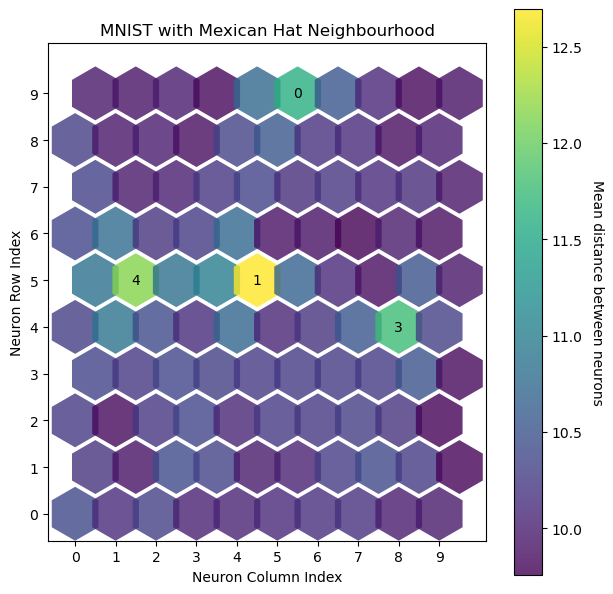

In [417]:
mnist_mexican_hat_hexagon.plot_umatrix(X_sample, y_sample)

In [418]:
class_dist = mnist_mexican_hat_hexagon.class_distribution_in_neurons(X_sample, y_sample)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples                                                       Class Distribution                                                     
(0,0)          0                                                                                                                              Empty
(0,1)          0                                                                                                                              Empty
(0,2)          0                                                                                                                              Empty
(0,3)          0                                                                                                                              Empty
(0,4)          0                                                                                                                              Empty
(0,5)          0               

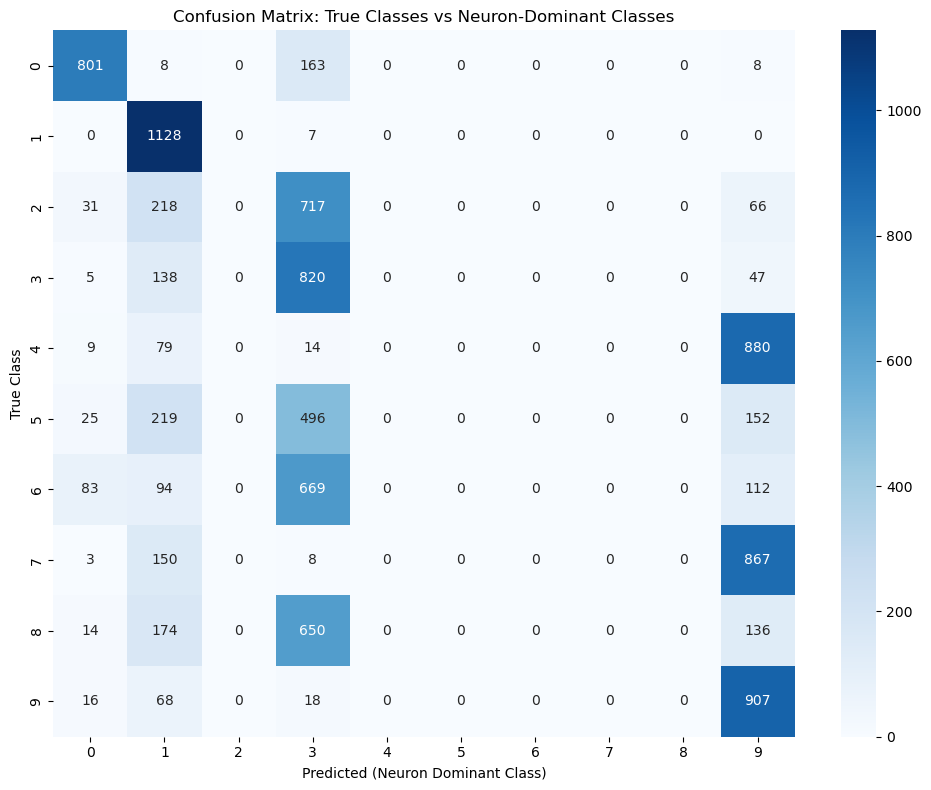

In [420]:
dominant_labels_train = mnist_mexican_hat_hexagon.class_distribution_in_neurons(X_test, y_test, return_dominant=True)
mnist_mexican_hat_hexagon.plot_confusion_matrix(data=X_test,true_labels=y_test,dominant_labels=dominant_labels_train)

In [419]:
class_to_neurons, neuron_stats = mnist_mexican_hat_hexagon.get_neurons_defining_class(X_sample, y_sample)
print_neuron_mapping(class_to_neurons, neuron_stats)

                NEURON CLASS MAPPING REPORT                 
Neuron  Dominant Class Purity             Associated Classes
 (9,5)             0.0  82.1%    [2, 6, 0, 9, 7, 3, 8, 5, 4]
 (5,4)             1.0  47.6% [2, 6, 0, 1, 9, 7, 3, 8, 5, 4]
 (4,8)             3.0  22.9% [2, 6, 0, 1, 9, 7, 3, 8, 5, 4]
 (5,1)             4.0  29.8%    [2, 6, 0, 9, 7, 3, 8, 5, 4]
 (0,0)             NaN   0.0%                             []
 (0,1)             NaN   0.0%                             []
 (0,2)             NaN   0.0%                             []
 (0,3)             NaN   0.0%                             []
 (0,4)             NaN   0.0%                             []
 (0,5)             NaN   0.0%                             []
 (0,6)             NaN   0.0%                             []
 (0,7)             NaN   0.0%                             []
 (0,8)             NaN   0.0%                             []
 (0,9)             NaN   0.0%                             []
 (1,0)             NaN  

### Human Activity dataset

In [465]:
X_train = np.loadtxt('data/UCI HAR Dataset/train/X_train.txt')
X_test = np.loadtxt('data/UCI HAR Dataset/test/X_test.txt')

y_train = np.loadtxt('data/UCI HAR Dataset/train/y_train.txt', dtype=int)
y_test = np.loadtxt('data/UCI HAR Dataset/test/y_test.txt', dtype=int)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7352, 561)
y_train shape: (7352,)
X_test shape: (2947, 561)
y_test shape: (2947,)


#### Human Activity rectangular gaussian

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 1.0000
  Quantization Error: 4.0344
  Silhouette Score: -0.0353
  Davies-Bouldin Index: 3.3185
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.3679
  Quantization Error: 3.5435
  Silhouette Score: 0.0570
  Davies-Bouldin Index: 2.7343
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.1353
  Quantization Error: 3.3788
  Silhouette Score: 0.0768
  Davies-Bouldin Index: 2.3572
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.0498
  Quantization Error: 3.2995
  Silhouette Score: 0.0796
  Davies-Bouldin Index: 2.3037
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0183
  Quantization Error: 3.2889
  Silhouette Score: 0.0783
  Davies-Bouldin Index: 2.2826
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0067
  Quantization Error: 3.2886
  Silhouette Score: 0.0781
  Davies-Bouldin 

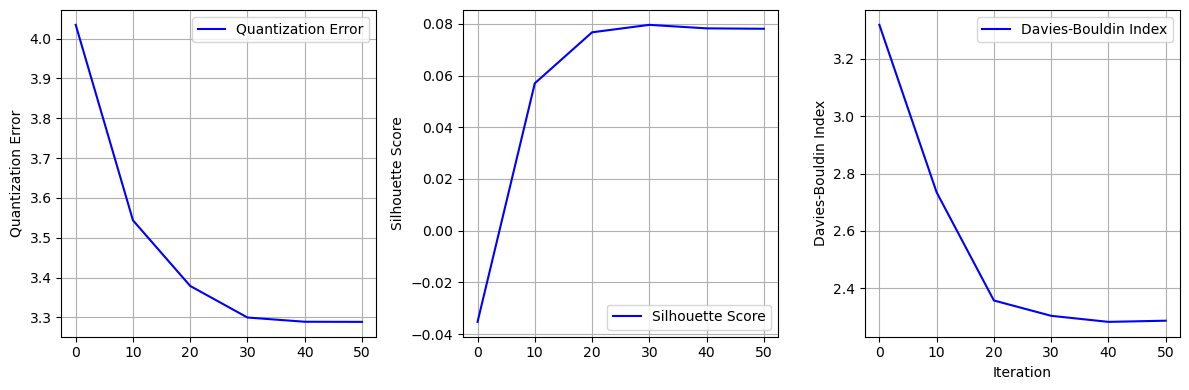

In [ ]:
ha_gaussian_rectangular = KohonenNetwork(M=10,N=10, input_dim=561, neighbourhood_function='gaussian', topology='rectangular')
ha_gaussian_rectangular.fit(X_train, number_of_iterations=60, lambda_=10, sigma_t=1.0, s=1.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

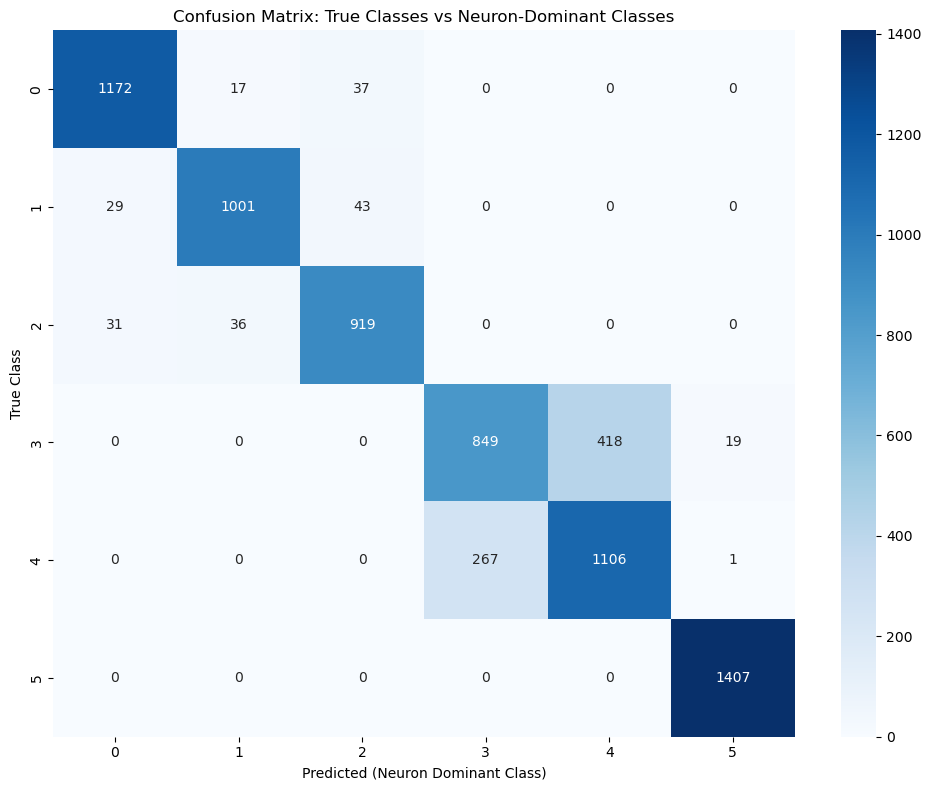

In [369]:
ha_gaussian_rectangular.plot_confusion_matrix(data=X_train, true_labels=y_train)

In [370]:
class_dist = ha_gaussian_rectangular.class_distribution_in_neurons(X_train, y_train)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples          Class Distribution         
(0,0)       124                   4:113(91.1%), 5:11(8.9%)
(0,1)        62                               4:62(100.0%)
(0,2)        37                               6:37(100.0%)
(0,3)       157                  4:111(70.7%), 5:46(29.3%)
(0,4)        57                   4:15(26.3%), 5:42(73.7%)
(0,5)         4                                5:4(100.0%)
(0,6)       250                  4:88(35.2%), 5:162(64.8%)
(0,7)       137                    4:135(98.5%), 5:2(1.5%)
(0,8)       156                  4:30(19.2%), 5:126(80.8%)
(0,9)       274                              6:274(100.0%)
(1,0)        65                   4:11(16.9%), 5:54(83.1%)
(1,1)       151                   4:69(45.7%), 5:82(54.3%)
(1,2)       105                   4:62(59.0%), 5:43(41.0%)
(1,3)       216                  4:33(15.3%), 5:183(84.7%)
(1,4)       146                   

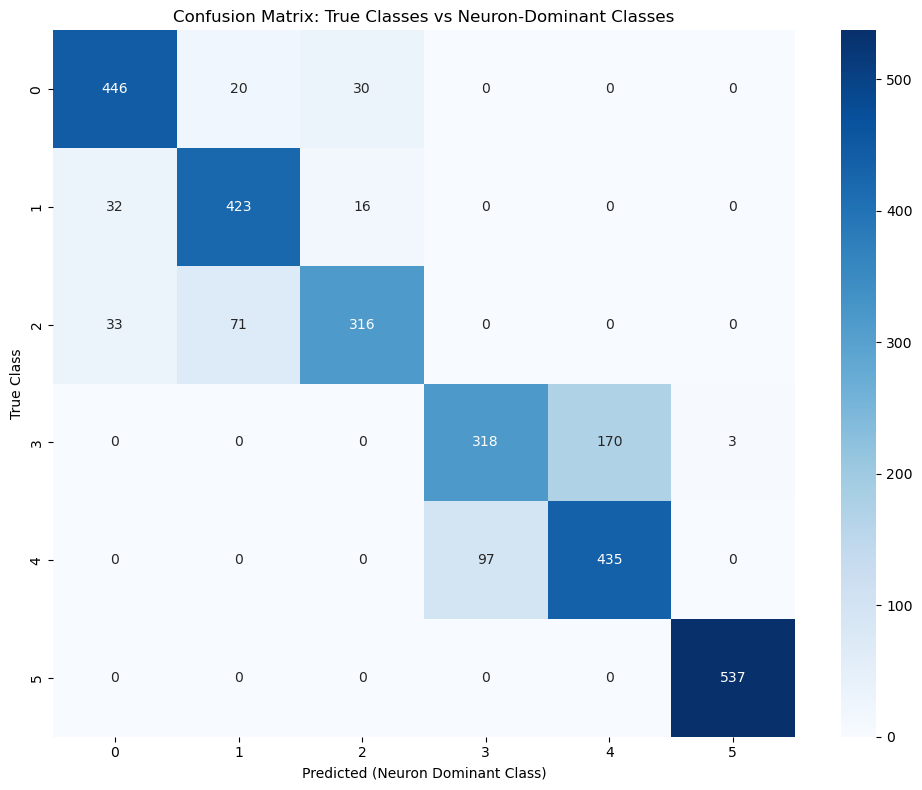

In [371]:
dominant_labels_train = ha_gaussian_rectangular.class_distribution_in_neurons(X_train, y_train, return_dominant=True)
ha_gaussian_rectangular.plot_confusion_matrix(data=X_test,true_labels=y_test,dominant_labels=dominant_labels_train)

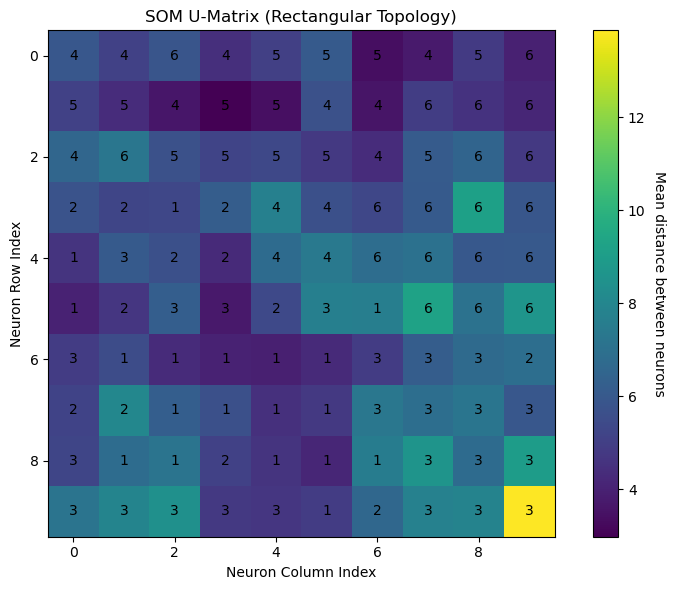

In [372]:
ha_gaussian_rectangular.plot_umatrix(X_train, y_train)

#### Human Activity rectangular mexican hat

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 1.0000
  Quantization Error: 6.3097
  Silhouette Score: 0.3997
  Davies-Bouldin Index: 1.4132
Iteration 10:
  Learning Rate (alpha): 0.6065
  Neighborhood Size (sigma): 0.6065
  Quantization Error: 5.1041
  Silhouette Score: 0.1904
  Davies-Bouldin Index: 2.0581
Iteration 20:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.3679
  Quantization Error: 4.5832
  Silhouette Score: 0.1131
  Davies-Bouldin Index: 2.5414
Iteration 30:
  Learning Rate (alpha): 0.2231
  Neighborhood Size (sigma): 0.2231
  Quantization Error: 4.3985
  Silhouette Score: 0.1789
  Davies-Bouldin Index: 1.8610
Iteration 40:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.1353
  Quantization Error: 4.2222
  Silhouette Score: 0.1641
  Davies-Bouldin Index: 2.1328
Iteration 50:
  Learning Rate (alpha): 0.0821
  Neighborhood Size (sigma): 0.0821
  Quantization Error: 4.2106
  Silhouette Score: 0.1646
  Davies-Bouldin I

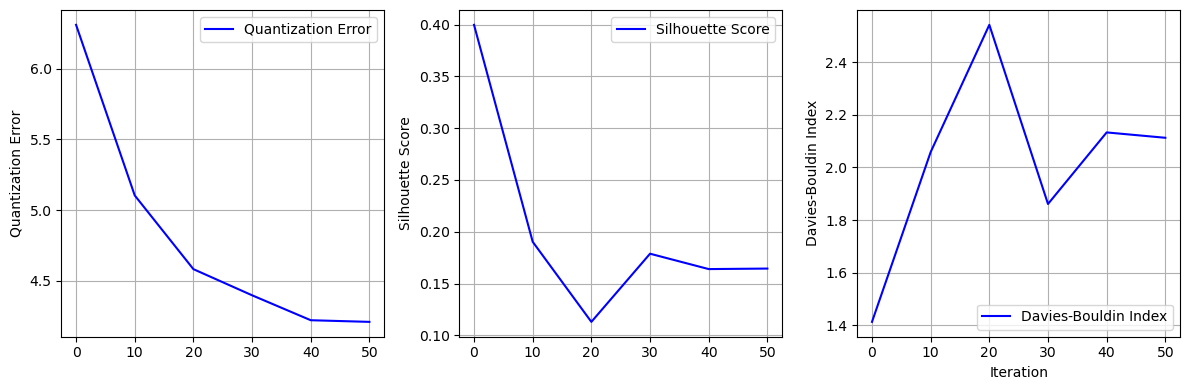

In [443]:
ha_mexican_hat_rectangular = KohonenNetwork(M=10,N=10, input_dim=561, neighbourhood_function='mexican_hat', topology='rectangular')
ha_mexican_hat_rectangular.fit(X_train, number_of_iterations=60, lambda_=20, sigma_t=1.0, s=10.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

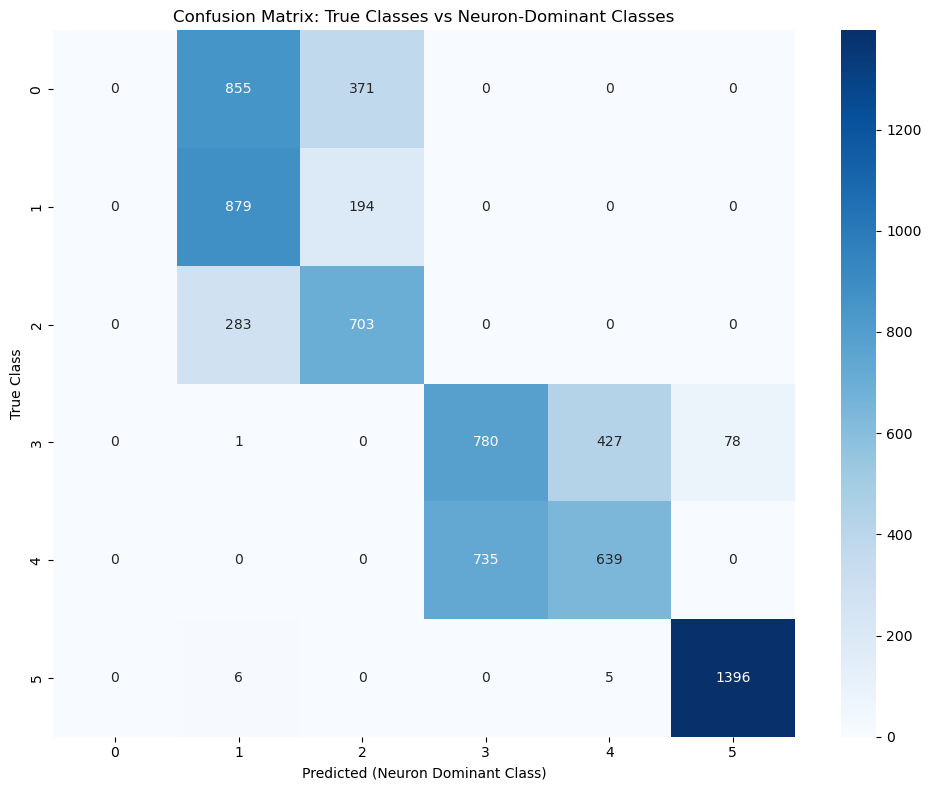

In [445]:
ha_mexican_hat_rectangular.plot_confusion_matrix(X_train, y_train)

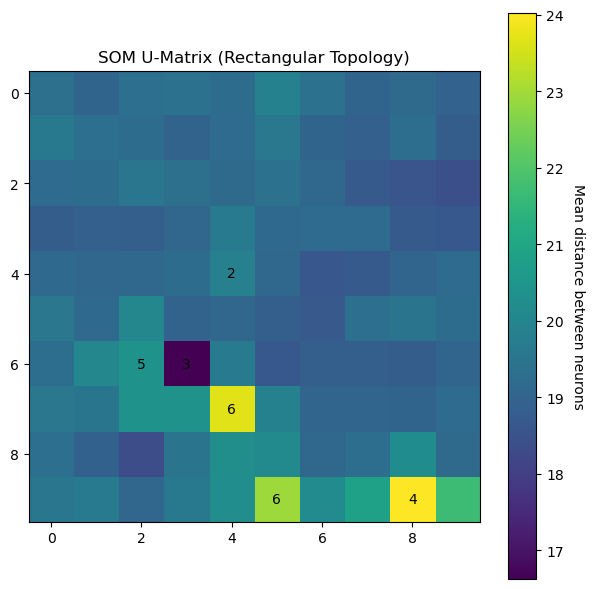

In [446]:
ha_mexican_hat_rectangular.plot_umatrix(X_train, y_train)

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 0.5000
  Quantization Error: 6.1724
  Silhouette Score: 0.3947
  Davies-Bouldin Index: 1.4480
Iteration 10:
  Learning Rate (alpha): 0.6065
  Neighborhood Size (sigma): 0.3033
  Quantization Error: 4.9507
  Silhouette Score: 0.0955
  Davies-Bouldin Index: 2.6242
Iteration 20:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.1839
  Quantization Error: 4.4774
  Silhouette Score: 0.1332
  Davies-Bouldin Index: 2.3668
Iteration 30:
  Learning Rate (alpha): 0.2231
  Neighborhood Size (sigma): 0.1116
  Quantization Error: 4.3044
  Silhouette Score: 0.1441
  Davies-Bouldin Index: 2.1174
Iteration 40:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.0677
  Quantization Error: 4.2492
  Silhouette Score: 0.1696
  Davies-Bouldin Index: 2.1719
Iteration 50:
  Learning Rate (alpha): 0.0821
  Neighborhood Size (sigma): 0.0410
  Quantization Error: 4.1582
  Silhouette Score: 0.1467
  Davies-Bouldin I

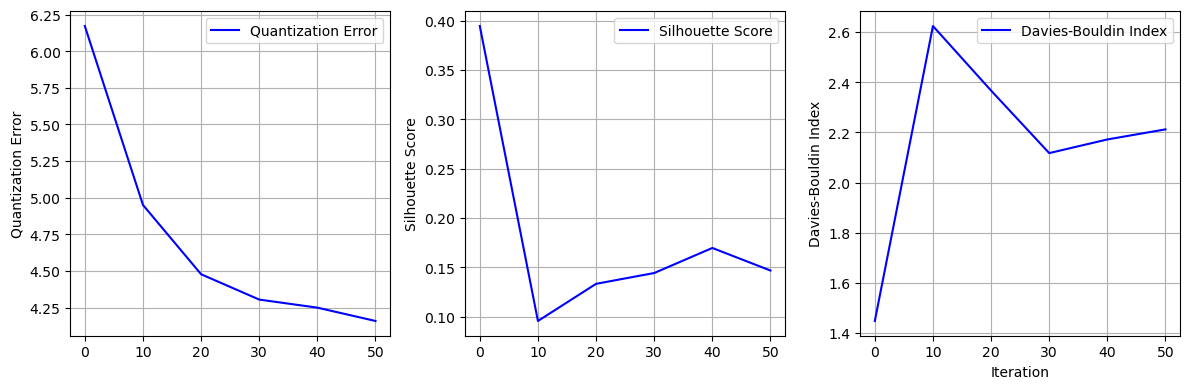

In [450]:
ha_mexican_hat_rectangular = KohonenNetwork(M=10,N=10, input_dim=561, neighbourhood_function='mexican_hat', topology='rectangular')
ha_mexican_hat_rectangular.fit(X_train, number_of_iterations=60, lambda_=20, sigma_t=0.5, s=10.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

#### Human Activity hexagon gaussian

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 1.0000
  Quantization Error: 4.0361
  Silhouette Score: -0.0272
  Davies-Bouldin Index: 3.3937
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.3679
  Quantization Error: 3.5398
  Silhouette Score: 0.0617
  Davies-Bouldin Index: 2.7231
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.1353
  Quantization Error: 3.3671
  Silhouette Score: 0.0767
  Davies-Bouldin Index: 2.4218
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.0498
  Quantization Error: 3.3083
  Silhouette Score: 0.0748
  Davies-Bouldin Index: 2.3946
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0183
  Quantization Error: 3.2944
  Silhouette Score: 0.0744
  Davies-Bouldin Index: 2.3679
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0067
  Quantization Error: 3.2973
  Silhouette Score: 0.0730
  Davies-Bouldin 

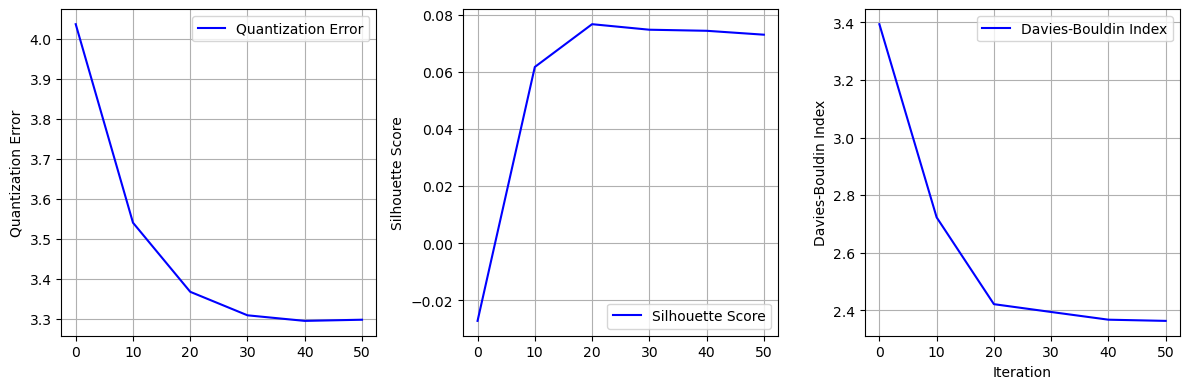

In [ ]:
ha_gaussian_hexagon = KohonenNetwork(M=10,N=10, input_dim=561, neighbourhood_function='gaussian', topology='hexagonal')
ha_gaussian_hexagon.fit(X_train, number_of_iterations=60, lambda_=10, sigma_t=1.0, s=1.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

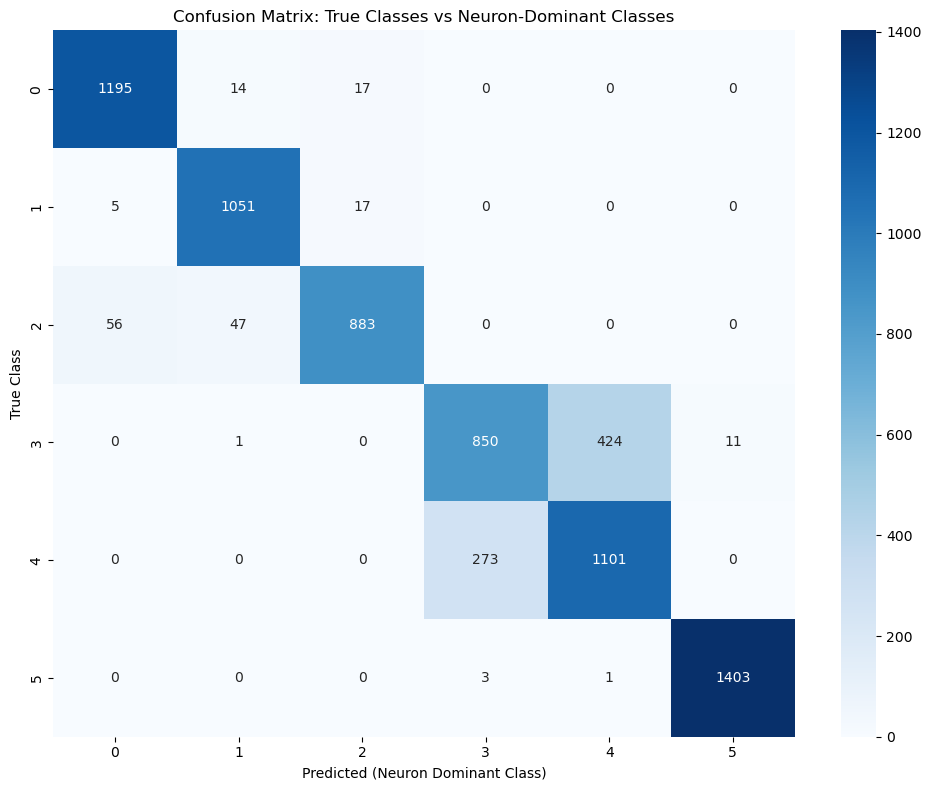

In [391]:
ha_gaussian_hexagon.plot_confusion_matrix(data=X_train, true_labels=y_train)

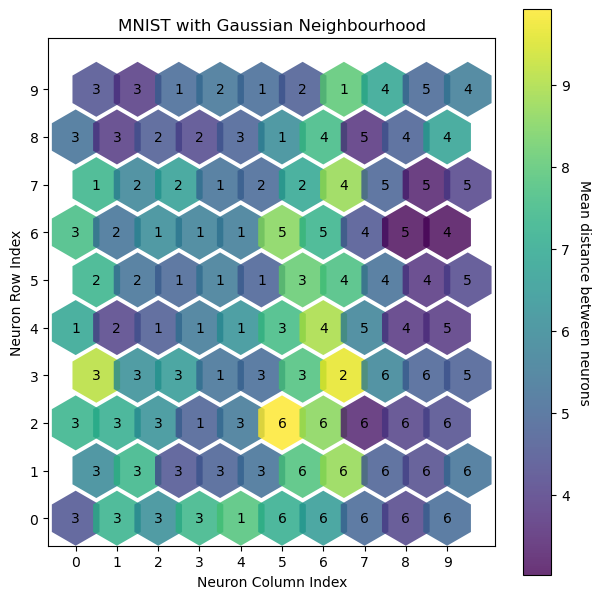

In [393]:
ha_gaussian_hexagon.plot_umatrix(X_train, y_train)

In [392]:
class_dist = ha_gaussian_hexagon.class_distribution_in_neurons(X_train, y_train)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples               Class Distribution             
(0,0)        15                                        3:15(100.0%)
(0,1)         3                                         3:3(100.0%)
(0,2)        16                  1:2(12.5%), 2:5(31.2%), 3:9(56.2%)
(0,3)        18                                        3:18(100.0%)
(0,4)        33                                        1:33(100.0%)
(0,5)        17                                        6:17(100.0%)
(0,6)        75                                        6:75(100.0%)
(0,7)       182                             4:1(0.5%), 6:181(99.5%)
(0,8)       190                                       6:190(100.0%)
(0,9)        32                                        6:32(100.0%)
(1,0)        11                              1:1(9.1%), 3:10(90.9%)
(1,1)         1                                         3:1(100.0%)
(1,2)        19                    

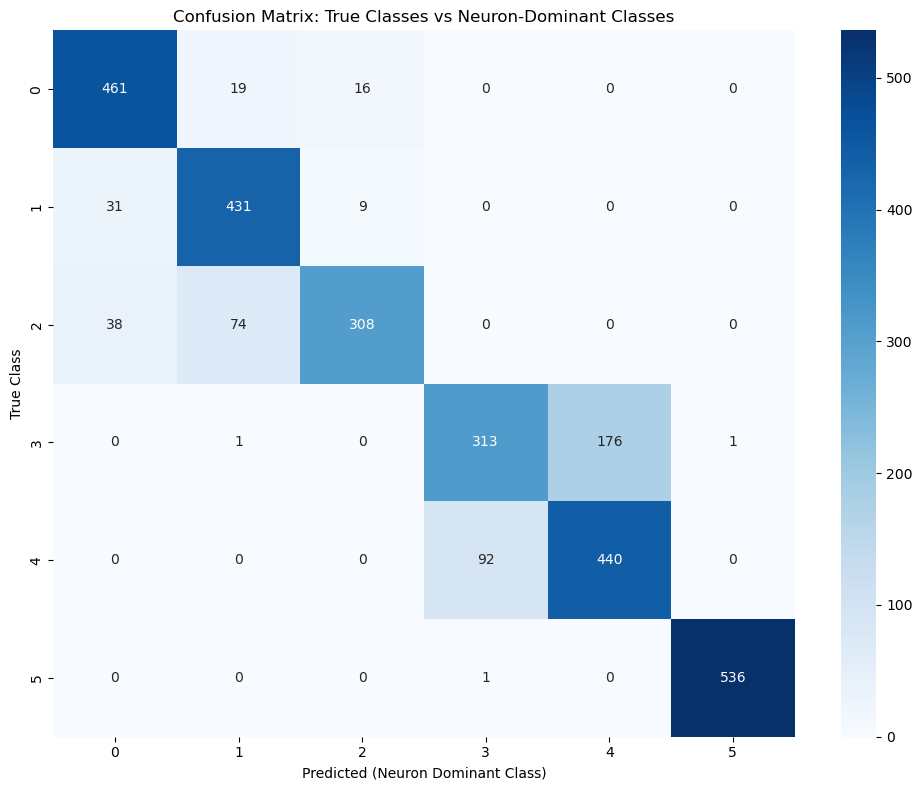

In [394]:
dominant_labels_train = ha_gaussian_hexagon.class_distribution_in_neurons(X_train, y_train, return_dominant=True)
ha_gaussian_hexagon.plot_confusion_matrix(data=X_test,true_labels=y_test,dominant_labels=dominant_labels_train)

hexagonal with larger sigma value

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 5.0000
  Quantization Error: 5.6715
  Silhouette Score: -0.0144
  Davies-Bouldin Index: 3.3613
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 1.8394
  Quantization Error: 4.1160
  Silhouette Score: -0.0223
  Davies-Bouldin Index: 4.3870
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.6767
  Quantization Error: 3.5436
  Silhouette Score: 0.0266
  Davies-Bouldin Index: 3.4200
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.2489
  Quantization Error: 3.2959
  Silhouette Score: 0.0650
  Davies-Bouldin Index: 2.5406
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0916
  Quantization Error: 3.2845
  Silhouette Score: 0.0658
  Davies-Bouldin Index: 2.5290
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0337
  Quantization Error: 3.2841
  Silhouette Score: 0.0656
  Davies-Bouldin

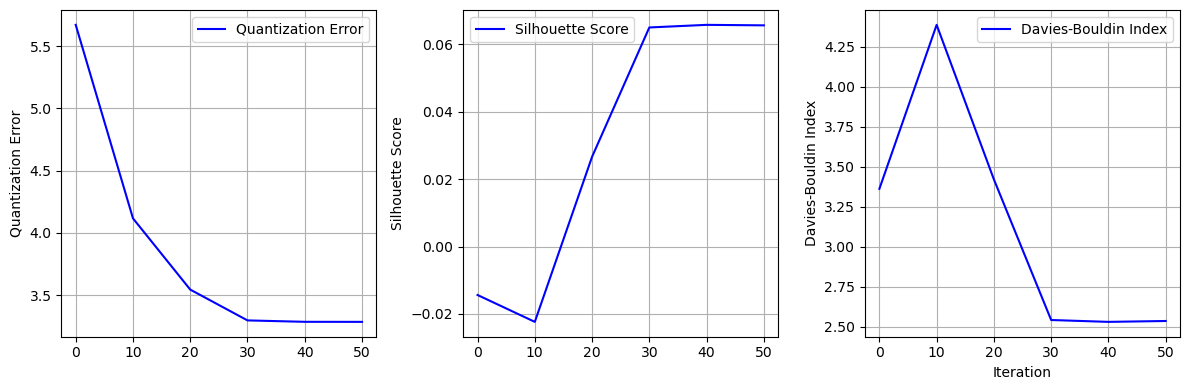

In [395]:
ha_gaussian_hexagon_sigma = KohonenNetwork(M=10,N=10, input_dim=561, neighbourhood_function='gaussian', topology='hexagonal')
ha_gaussian_hexagon_sigma.fit(X_train, number_of_iterations=60, lambda_=10, sigma_t=5.0, s=1.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

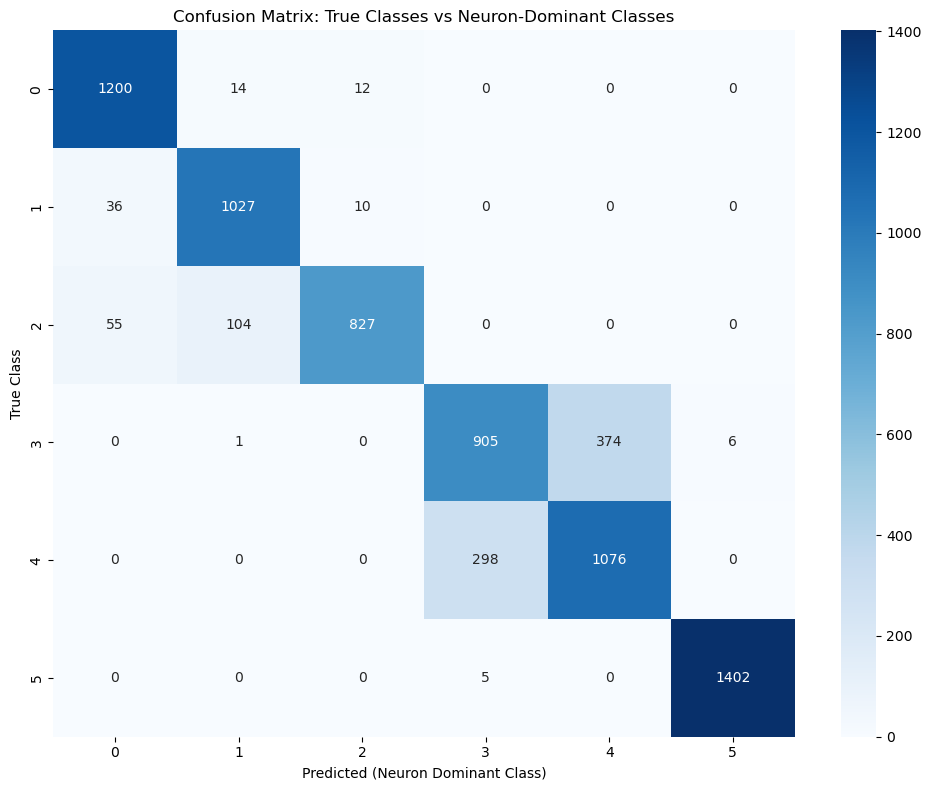

In [396]:
ha_gaussian_hexagon_sigma.plot_confusion_matrix(data=X_train, true_labels=y_train)

In [397]:
class_dist = ha_gaussian_hexagon_sigma.class_distribution_in_neurons(X_train, y_train)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples               Class Distribution             
(0,0)        44                                        1:44(100.0%)
(0,1)        35                              1:34(97.1%), 2:1(2.9%)
(0,2)        51                              1:50(98.0%), 2:1(2.0%)
(0,3)        43                                        1:43(100.0%)
(0,4)         8                                         6:8(100.0%)
(0,5)       112                                       6:112(100.0%)
(0,6)       143                             4:6(4.2%), 6:137(95.8%)
(0,7)       174                                       6:174(100.0%)
(0,8)        74                                        6:74(100.0%)
(0,9)       102                                       6:102(100.0%)
(1,0)        66               1:37(56.1%), 2:15(22.7%), 3:14(21.2%)
(1,1)        83                              1:82(98.8%), 3:1(1.2%)
(1,2)        67                    

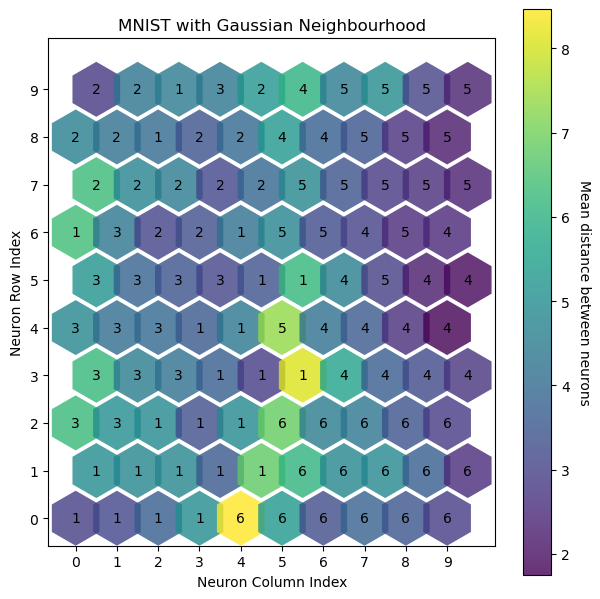

In [398]:
ha_gaussian_hexagon_sigma.plot_umatrix(X_train, y_train)

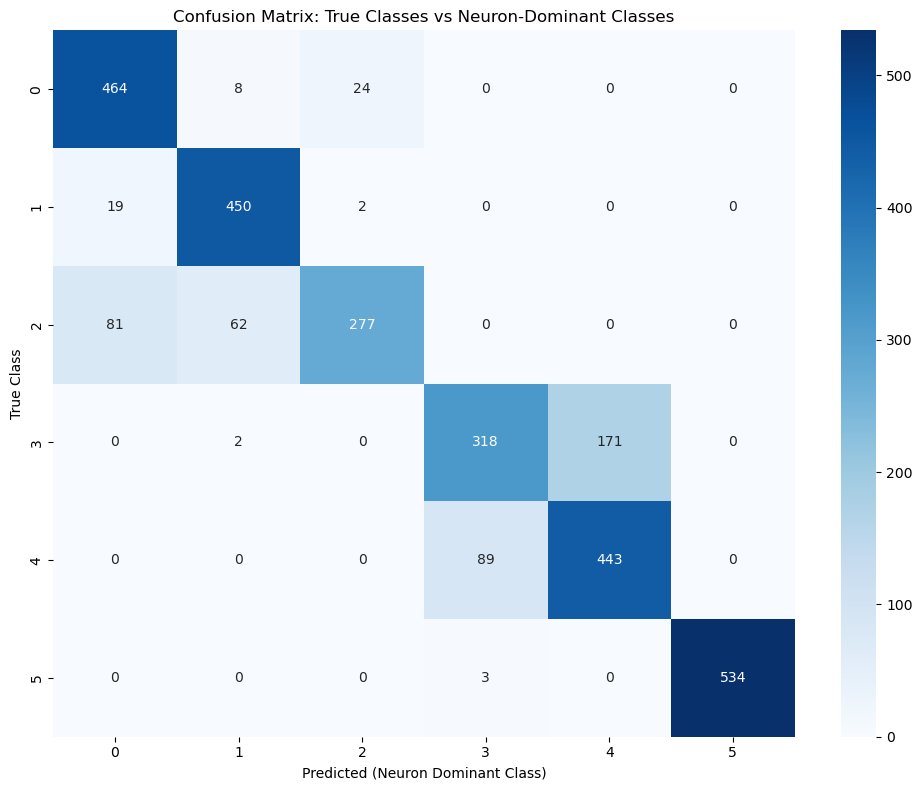

In [399]:
dominant_labels_train = ha_gaussian_hexagon_sigma.class_distribution_in_neurons(X_train, y_train, return_dominant=True)
ha_gaussian_hexagon_sigma.plot_confusion_matrix(data=X_test,true_labels=y_test,dominant_labels=dominant_labels_train)

#### Human Activity hexagon mexican hat

Iteration 0:
  Learning Rate (alpha): 1.0000
  Neighborhood Size (sigma): 0.1000
  Quantization Error: 7.0401
  Silhouette Score: 0.3376
  Davies-Bouldin Index: 1.0740
Iteration 10:
  Learning Rate (alpha): 0.3679
  Neighborhood Size (sigma): 0.0368
  Quantization Error: 4.5481
  Silhouette Score: 0.1267
  Davies-Bouldin Index: 2.4573
Iteration 20:
  Learning Rate (alpha): 0.1353
  Neighborhood Size (sigma): 0.0135
  Quantization Error: 4.2921
  Silhouette Score: 0.1690
  Davies-Bouldin Index: 1.9119
Iteration 30:
  Learning Rate (alpha): 0.0498
  Neighborhood Size (sigma): 0.0050
  Quantization Error: 4.1090
  Silhouette Score: 0.1334
  Davies-Bouldin Index: 2.2106
Iteration 40:
  Learning Rate (alpha): 0.0183
  Neighborhood Size (sigma): 0.0018
  Quantization Error: 4.0743
  Silhouette Score: 0.1273
  Davies-Bouldin Index: 2.2350
Iteration 50:
  Learning Rate (alpha): 0.0067
  Neighborhood Size (sigma): 0.0007
  Quantization Error: 4.0614
  Silhouette Score: 0.1262
  Davies-Bouldin I

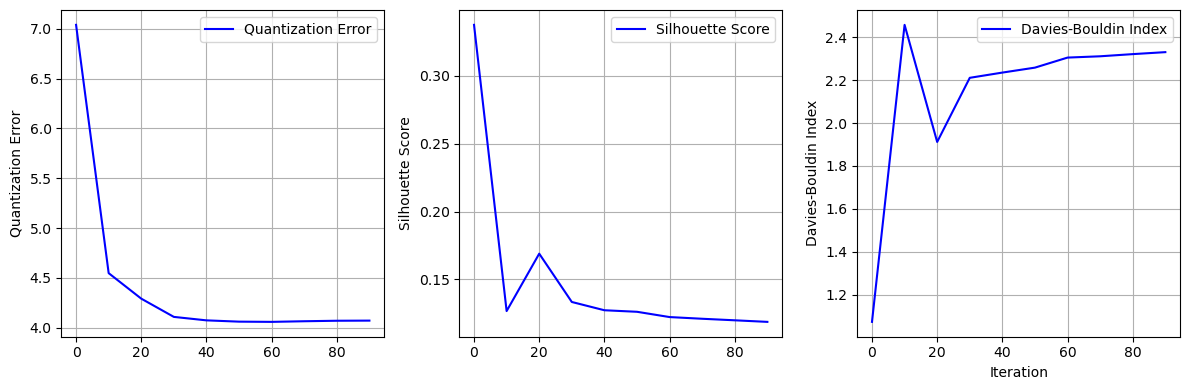

In [426]:
ha_mexican_hat_hexagon = KohonenNetwork(M=10,N=10, input_dim=561, neighbourhood_function='mexican_hat', topology='hexagonal')
ha_mexican_hat_hexagon.fit(X_train, number_of_iterations=100, lambda_=10, sigma_t=0.1, s=5.0, 
                                       plot_eval_metrics=True, eval_every=10, verbose=True)

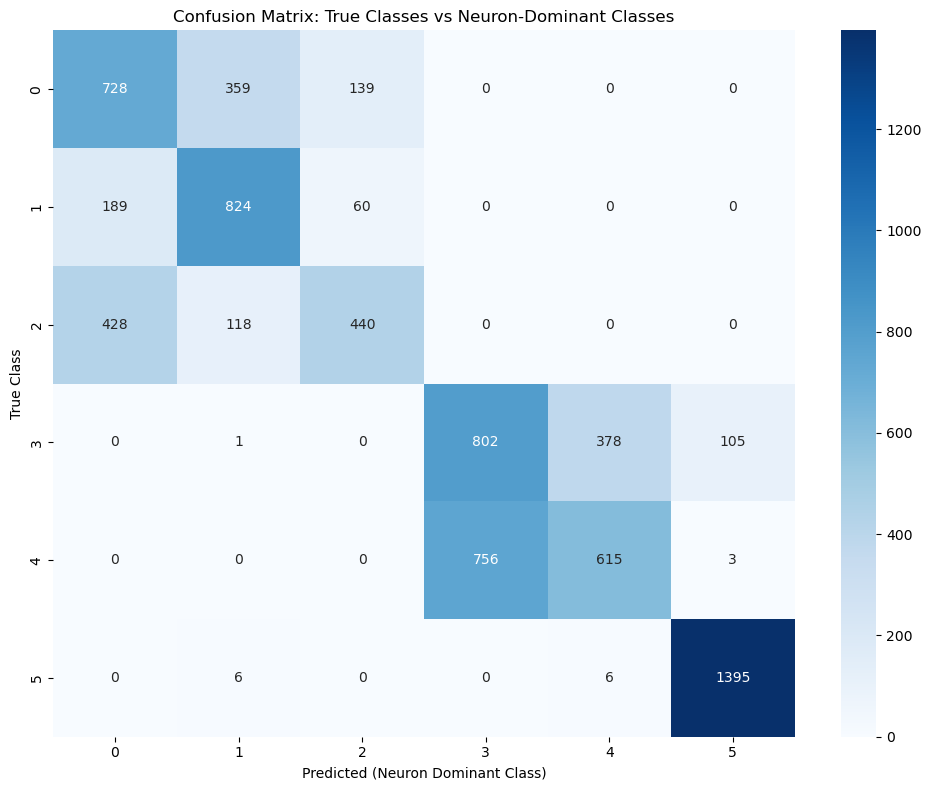

In [427]:
ha_mexican_hat_hexagon.plot_confusion_matrix(X_train, y_train)

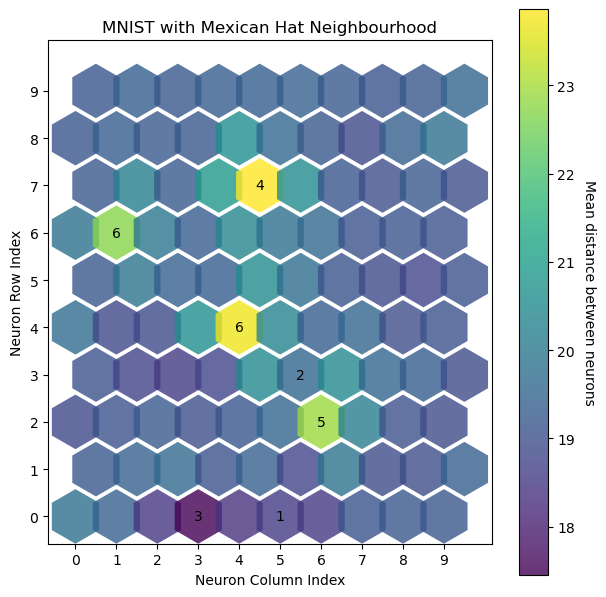

In [428]:
ha_mexican_hat_hexagon.plot_umatrix(X_train, y_train)

In [466]:
class_to_neurons, neuron_stats = ha_mexican_hat_hexagon.get_neurons_defining_class(X_train, y_train)
print_neuron_mapping(class_to_neurons, neuron_stats)

                NEURON CLASS MAPPING REPORT                 
Neuron  Dominant Class Purity Associated Classes
 (0,5)             1.0  54.1%          [1, 3, 2]
 (3,5)             2.0  63.0%    [4, 6, 1, 3, 2]
 (0,3)             3.0  68.9%          [1, 3, 2]
 (7,4)             4.0  51.5%             [5, 4]
 (2,6)             5.0  61.6%          [5, 4, 6]
 (4,4)             6.0  95.8%             [4, 6]
 (6,1)             6.0  82.6%          [5, 4, 6]
 (0,0)             NaN   0.0%                 []
 (0,1)             NaN   0.0%                 []
 (0,2)             NaN   0.0%                 []
 (0,4)             NaN   0.0%                 []
 (0,6)             NaN   0.0%                 []
 (0,7)             NaN   0.0%                 []
 (0,8)             NaN   0.0%                 []
 (0,9)             NaN   0.0%                 []
 (1,0)             NaN   0.0%                 []
 (1,1)             NaN   0.0%                 []
 (1,2)             NaN   0.0%                 []
 (1,3)  

In [434]:
class_dist = ha_mexican_hat_hexagon.class_distribution_in_neurons(X_train, y_train)
print_class_distribution(class_dist)

                         CLASS DISTRIBUTION IN NEURONS                          
Neuron  Total Samples                       Class Distribution                     
(0,0)          0                                                              Empty
(0,1)          0                                                              Empty
(0,2)          0                                                              Empty
(0,3)        639                             1:139(21.8%), 2:60(9.4%), 3:440(68.9%)
(0,4)          0                                                              Empty
(0,5)       1345                           1:728(54.1%), 2:189(14.1%), 3:428(31.8%)
(0,6)          0                                                              Empty
(0,7)          0                                                              Empty
(0,8)          0                                                              Empty
(0,9)          0                                                              E